MRINAL KADAM USC ID: 3135945534

In [1]:
# Import all required packages and libraries

import pandas as pd 
import numpy as np

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

import weka.core.jvm as jvm
jvm.start()
import weka.core.converters as convert
from weka.classifiers import Classifier, Evaluation, FilteredClassifier
from weka.core.classes import Random
import weka.plot.classifiers as plcls
from weka.filters import Filter
from weka.core.packages import install_package, is_installed
install_package("SMOTE")
is_installed("SMOTE")

from time import time

import xgboost as xgb

from IPython.display import Image

import warnings

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


# 1. The LASSO and Boosting for Regression

# (a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the  first 1495 rows of data as the training set and the rest as the test set.

In [3]:
# Read the input file into a dataframe

df_1 = pd.read_csv("../data/communities.data", header=None)
df_1

0   1      2                    3    4     5     6     7     8     9    \
0       8   ?      ?         Lakewoodcity    1  0.19  0.33  0.02  0.90  0.12   
1      53   ?      ?          Tukwilacity    1  0.00  0.16  0.12  0.74  0.45   
2      24   ?      ?         Aberdeentown    1  0.00  0.42  0.49  0.56  0.17   
3      34   5  81440  Willingborotownship    1  0.04  0.77  1.00  0.08  0.12   
4      42  95   6096    Bethlehemtownship    1  0.01  0.55  0.02  0.95  0.09   
...   ...  ..    ...                  ...  ...   ...   ...   ...   ...   ...   
1989   12   ?      ?    TempleTerracecity   10  0.01  0.40  0.10  0.87  0.12   
1990    6   ?      ?          Seasidecity   10  0.05  0.96  0.46  0.28  0.83   
1991    9   9  80070        Waterburytown   10  0.16  0.37  0.25  0.69  0.04   
1992   25  17  72600          Walthamcity   10  0.08  0.51  0.06  0.87  0.22   
1993    6   ?      ?          Ontariocity   10  0.20  0.78  0.14  0.46  0.24   

      ...   118   119   120   121   122   123  124   125   126   127  
0     ...  0.12  0.26  0.20  0.06  0.04   0.9  0.5  0.32  0.14  0.20  
1     ...  0.02  0.12  0.45     ?     ?     ?    ?  0.00     ?  0.67  
2     ...  0.01  0.21  0.02     ?     ?     ?    ?  0.00     ?  0.43  
3     ...  0.02  0.39  0.28     ?     ?     ?    ?  0.00     ?  0.12  
4     ...  0.04  0.09  0.02     ?     ?     ?    ?  0.00     ?  0.03  
...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...  
1989  ...  0.01  0.28  0.05     ?     ?     ?    ?  0.00     ?  0.09  
1990  ...  0.02  0.37  0.20     ?     ?     ?    ?  0.00     ?  0.45  
1991  ...  0.08  0.32  0.18  0.08  0.06  0.78    0  0.91  0.28  0.23  
1992  ...  0.03  0.38  0.33  0.02  0.02  0.79    0  0.22  0.18  0.19  
1993  ...  0.11  0.30  0.05  0.08  0.04  0.73  0.5  1.00  0.13  0.48  

[1994 rows x 128 columns]

In [4]:
# Read the column names into an array

cols = []

file = open('../data/communities.names')
for line in file.readlines():
    if line.startswith("@attribute"):
        cols.append(line.split(' ')[1])
    
print(cols)

['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOn

In [5]:
# Assign these columnn names in the dataframe

df_comm = pd.DataFrame(data=df_1.values,columns=cols)
df_comm

state county community        communityname fold population  \
0        8      ?         ?         Lakewoodcity    1       0.19   
1       53      ?         ?          Tukwilacity    1        0.0   
2       24      ?         ?         Aberdeentown    1        0.0   
3       34      5     81440  Willingborotownship    1       0.04   
4       42     95      6096    Bethlehemtownship    1       0.01   
...    ...    ...       ...                  ...  ...        ...   
1989    12      ?         ?    TempleTerracecity   10       0.01   
1990     6      ?         ?          Seasidecity   10       0.05   
1991     9      9     80070        Waterburytown   10       0.16   
1992    25     17     72600          Walthamcity   10       0.08   
1993     6      ?         ?          Ontariocity   10        0.2   

     householdsize racepctblack racePctWhite racePctAsian  ... LandArea  \
0             0.33         0.02          0.9         0.12  ...     0.12   
1             0.16         0.12         0.74         0.45  ...     0.02   
2             0.42         0.49         0.56         0.17  ...     0.01   
3             0.77          1.0         0.08         0.12  ...     0.02   
4             0.55         0.02         0.95         0.09  ...     0.04   
...            ...          ...          ...          ...  ...      ...   
1989           0.4          0.1         0.87         0.12  ...     0.01   
1990          0.96         0.46         0.28         0.83  ...     0.02   
1991          0.37         0.25         0.69         0.04  ...     0.08   
1992          0.51         0.06         0.87         0.22  ...     0.03   
1993          0.78         0.14         0.46         0.24  ...     0.11   

     PopDens PctUsePubTrans PolicCars PolicOperBudg LemasPctPolicOnPatr  \
0       0.26            0.2      0.06          0.04                 0.9   
1       0.12           0.45         ?             ?                   ?   
2       0.21           0.02         ?             ?                   ?   
3       0.39           0.28         ?             ?                   ?   
4       0.09           0.02         ?             ?                   ?   
...      ...            ...       ...           ...                 ...   
1989    0.28           0.05         ?             ?                   ?   
1990    0.37            0.2         ?             ?                   ?   
1991    0.32           0.18      0.08          0.06                0.78   
1992    0.38           0.33      0.02          0.02                0.79   
1993     0.3           0.05      0.08          0.04                0.73   

     LemasGangUnitDeploy LemasPctOfficDrugUn PolicBudgPerPop  \
0                    0.5                0.32            0.14   
1                      ?                 0.0               ?   
2                      ?                 0.0               ?   
3                      ?                 0.0               ?   
4                      ?                 0.0               ?   
...                  ...                 ...             ...   
1989                   ?                 0.0               ?   
1990                   ?                 0.0               ?   
1991                   0                0.91            0.28   
1992                   0                0.22            0.18   
1993                 0.5                 1.0            0.13   

     ViolentCrimesPerPop  
0                    0.2  
1                   0.67  
2                   0.43  
3                   0.12  
4                   0.03  
...                  ...  
1989                0.09  
1990                0.45  
1991                0.23  
1992                0.19  
1993                0.48  

[1994 rows x 128 columns]

# (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [6]:
# In the original file, missing values are represented by '?'. Replace this with Nan in the dataframe.

df_comm = df_comm.apply(lambda x: (x.replace("?",np.nan)),axis = 0)
df_comm

state county community        communityname fold population  \
0        8    NaN       NaN         Lakewoodcity    1       0.19   
1       53    NaN       NaN          Tukwilacity    1        0.0   
2       24    NaN       NaN         Aberdeentown    1        0.0   
3       34      5     81440  Willingborotownship    1       0.04   
4       42     95      6096    Bethlehemtownship    1       0.01   
...    ...    ...       ...                  ...  ...        ...   
1989    12    NaN       NaN    TempleTerracecity   10       0.01   
1990     6    NaN       NaN          Seasidecity   10       0.05   
1991     9      9     80070        Waterburytown   10       0.16   
1992    25     17     72600          Walthamcity   10       0.08   
1993     6    NaN       NaN          Ontariocity   10        0.2   

     householdsize racepctblack racePctWhite racePctAsian  ... LandArea  \
0             0.33         0.02          0.9         0.12  ...     0.12   
1             0.16         0.12         0.74         0.45  ...     0.02   
2             0.42         0.49         0.56         0.17  ...     0.01   
3             0.77          1.0         0.08         0.12  ...     0.02   
4             0.55         0.02         0.95         0.09  ...     0.04   
...            ...          ...          ...          ...  ...      ...   
1989           0.4          0.1         0.87         0.12  ...     0.01   
1990          0.96         0.46         0.28         0.83  ...     0.02   
1991          0.37         0.25         0.69         0.04  ...     0.08   
1992          0.51         0.06         0.87         0.22  ...     0.03   
1993          0.78         0.14         0.46         0.24  ...     0.11   

     PopDens PctUsePubTrans PolicCars PolicOperBudg LemasPctPolicOnPatr  \
0       0.26            0.2      0.06          0.04                 0.9   
1       0.12           0.45       NaN           NaN                 NaN   
2       0.21           0.02       NaN           NaN                 NaN   
3       0.39           0.28       NaN           NaN                 NaN   
4       0.09           0.02       NaN           NaN                 NaN   
...      ...            ...       ...           ...                 ...   
1989    0.28           0.05       NaN           NaN                 NaN   
1990    0.37            0.2       NaN           NaN                 NaN   
1991    0.32           0.18      0.08          0.06                0.78   
1992    0.38           0.33      0.02          0.02                0.79   
1993     0.3           0.05      0.08          0.04                0.73   

     LemasGangUnitDeploy LemasPctOfficDrugUn PolicBudgPerPop  \
0                    0.5                0.32            0.14   
1                    NaN                 0.0             NaN   
2                    NaN                 0.0             NaN   
3                    NaN                 0.0             NaN   
4                    NaN                 0.0             NaN   
...                  ...                 ...             ...   
1989                 NaN                 0.0             NaN   
1990                 NaN                 0.0             NaN   
1991                   0                0.91            0.28   
1992                   0                0.22            0.18   
1993                 0.5                 1.0            0.13   

     ViolentCrimesPerPop  
0                    0.2  
1                   0.67  
2                   0.43  
3                   0.12  
4                   0.03  
...                  ...  
1989                0.09  
1990                0.45  
1991                0.23  
1992                0.19  
1993                0.48  

[1994 rows x 128 columns]

In [7]:
# Ignore the non-predictive features

df_comm_1 = df_comm.iloc[:,5:]
df_comm_1

population householdsize racepctblack racePctWhite racePctAsian  \
0          0.19          0.33         0.02          0.9         0.12   
1           0.0          0.16         0.12         0.74         0.45   
2           0.0          0.42         0.49         0.56         0.17   
3          0.04          0.77          1.0         0.08         0.12   
4          0.01          0.55         0.02         0.95         0.09   
...         ...           ...          ...          ...          ...   
1989       0.01           0.4          0.1         0.87         0.12   
1990       0.05          0.96         0.46         0.28         0.83   
1991       0.16          0.37         0.25         0.69         0.04   
1992       0.08          0.51         0.06         0.87         0.22   
1993        0.2          0.78         0.14         0.46         0.24   

     racePctHisp agePct12t21 agePct12t29 agePct16t24 agePct65up  ... LandArea  \
0           0.17        0.34        0.47        0.29       0.32  ...     0.12   
1           0.07        0.26        0.59        0.35       0.27  ...     0.02   
2           0.04        0.39        0.47        0.28       0.32  ...     0.01   
3            0.1        0.51         0.5        0.34       0.21  ...     0.02   
4           0.05        0.38        0.38        0.23       0.36  ...     0.04   
...          ...         ...         ...         ...        ...  ...      ...   
1989        0.16        0.43        0.51        0.35        0.3  ...     0.01   
1990        0.32        0.69        0.86        0.73       0.14  ...     0.02   
1991        0.25        0.35         0.5        0.31       0.54  ...     0.08   
1992         0.1        0.58        0.74        0.63       0.41  ...     0.03   
1993        0.77         0.5        0.62         0.4       0.17  ...     0.11   

     PopDens PctUsePubTrans PolicCars PolicOperBudg LemasPctPolicOnPatr  \
0       0.26            0.2      0.06          0.04                 0.9   
1       0.12           0.45       NaN           NaN                 NaN   
2       0.21           0.02       NaN           NaN                 NaN   
3       0.39           0.28       NaN           NaN                 NaN   
4       0.09           0.02       NaN           NaN                 NaN   
...      ...            ...       ...           ...                 ...   
1989    0.28           0.05       NaN           NaN                 NaN   
1990    0.37            0.2       NaN           NaN                 NaN   
1991    0.32           0.18      0.08          0.06                0.78   
1992    0.38           0.33      0.02          0.02                0.79   
1993     0.3           0.05      0.08          0.04                0.73   

     LemasGangUnitDeploy LemasPctOfficDrugUn PolicBudgPerPop  \
0                    0.5                0.32            0.14   
1                    NaN                 0.0             NaN   
2                    NaN                 0.0             NaN   
3                    NaN                 0.0             NaN   
4                    NaN                 0.0             NaN   
...                  ...                 ...             ...   
1989                 NaN                 0.0             NaN   
1990                 NaN                 0.0             NaN   
1991                   0                0.91            0.28   
1992                   0                0.22            0.18   
1993                 0.5                 1.0            0.13   

     ViolentCrimesPerPop  
0                    0.2  
1                   0.67  
2                   0.43  
3                   0.12  
4                   0.03  
...                  ...  
1989                0.09  
1990                0.45  
1991                0.23  
1992                0.19  
1993                0.48  

[1994 rows x 123 columns]

In [8]:
# Calculate the missing percent proportion for each column 

missing_percent = df_comm_1.apply(lambda x: (x.isna().sum())/len(x),axis = 0)
missing_percent[missing_percent.values!=0]        

OtherPerCap             0.000502
LemasSwornFT            0.840020
LemasSwFTPerPop         0.840020
LemasSwFTFieldOps       0.840020
LemasSwFTFieldPerPop    0.840020
LemasTotalReq           0.840020
LemasTotReqPerPop       0.840020
PolicReqPerOffic        0.840020
PolicPerPop             0.840020
RacialMatchCommPol      0.840020
PctPolicWhite           0.840020
PctPolicBlack           0.840020
PctPolicHisp            0.840020
PctPolicAsian           0.840020
PctPolicMinor           0.840020
OfficAssgnDrugUnits     0.840020
NumKindsDrugsSeiz       0.840020
PolicAveOTWorked        0.840020
PolicCars               0.840020
PolicOperBudg           0.840020
LemasPctPolicOnPatr     0.840020
LemasGangUnitDeploy     0.840020
PolicBudgPerPop         0.840020
dtype: float64

As mentioned in the documentation, a limitation was that the LEMAS survey was of the police departments with at least a 100 officers, plus a random sample of smaller departments. For our purposes, communities not found in both census and crime datasets were omitted. Many communities are missing LEMAS data.
Hence most of the missing data might be for communities having police departments with less than a 100 officers.

Theoretically, 25 to 30% is the maximum missing values that are allowed, beyond which we might want to drop the variable from analysis. Here, we drop the columns having more than 80% missing data.

In [9]:
# Drop the columns with high missing percent proportion (>0.8)

df_comm_2 = df_comm_1.loc[:,missing_percent.values <= 0.8]

df_comm_final = pd.concat([df_comm.iloc[:,:5],df_comm_2],axis=1)
df_comm_final

state county community        communityname fold population  \
0        8    NaN       NaN         Lakewoodcity    1       0.19   
1       53    NaN       NaN          Tukwilacity    1        0.0   
2       24    NaN       NaN         Aberdeentown    1        0.0   
3       34      5     81440  Willingborotownship    1       0.04   
4       42     95      6096    Bethlehemtownship    1       0.01   
...    ...    ...       ...                  ...  ...        ...   
1989    12    NaN       NaN    TempleTerracecity   10       0.01   
1990     6    NaN       NaN          Seasidecity   10       0.05   
1991     9      9     80070        Waterburytown   10       0.16   
1992    25     17     72600          Walthamcity   10       0.08   
1993     6    NaN       NaN          Ontariocity   10        0.2   

     householdsize racepctblack racePctWhite racePctAsian  ... PctForeignBorn  \
0             0.33         0.02          0.9         0.12  ...           0.12   
1             0.16         0.12         0.74         0.45  ...           0.21   
2             0.42         0.49         0.56         0.17  ...           0.14   
3             0.77          1.0         0.08         0.12  ...           0.19   
4             0.55         0.02         0.95         0.09  ...           0.11   
...            ...          ...          ...          ...  ...            ...   
1989           0.4          0.1         0.87         0.12  ...           0.22   
1990          0.96         0.46         0.28         0.83  ...           0.53   
1991          0.37         0.25         0.69         0.04  ...           0.25   
1992          0.51         0.06         0.87         0.22  ...           0.45   
1993          0.78         0.14         0.46         0.24  ...           0.68   

     PctBornSameState PctSameHouse85 PctSameCity85 PctSameState85 LandArea  \
0                0.42            0.5          0.51           0.64     0.12   
1                 0.5           0.34           0.6           0.52     0.02   
2                0.49           0.54          0.67           0.56     0.01   
3                 0.3           0.73          0.64           0.65     0.02   
4                0.72           0.64          0.61           0.53     0.04   
...               ...            ...           ...            ...      ...   
1989             0.28           0.34          0.48           0.39     0.01   
1990             0.25           0.17           0.1            0.0     0.02   
1991             0.68           0.61          0.79           0.76     0.08   
1992             0.64           0.54          0.59           0.52     0.03   
1993              0.5           0.34          0.35           0.68     0.11   

     PopDens PctUsePubTrans LemasPctOfficDrugUn ViolentCrimesPerPop  
0       0.26            0.2                0.32                 0.2  
1       0.12           0.45                 0.0                0.67  
2       0.21           0.02                 0.0                0.43  
3       0.39           0.28                 0.0                0.12  
4       0.09           0.02                 0.0                0.03  
...      ...            ...                 ...                 ...  
1989    0.28           0.05                 0.0                0.09  
1990    0.37            0.2                 0.0                0.45  
1991    0.32           0.18                0.91                0.23  
1992    0.38           0.33                0.22                0.19  
1993     0.3           0.05                 1.0                0.48  

[1994 rows x 106 columns]

In [10]:
# Calculate the number of missing values in each column after dropping the columns with high missing percent proportion (>0.8) 

df_comm_final_missing = df_comm_final.isna().sum().to_frame(name='missing_values').reset_index()
df_comm_final_missing.rename({'index':'column_name'},axis=1,inplace=True)
df_comm_final_missing

column_name  missing_values
0                  state               0
1                 county            1174
2              community            1177
3          communityname               0
4                   fold               0
..                   ...             ...
101             LandArea               0
102              PopDens               0
103       PctUsePubTrans               0
104  LemasPctOfficDrugUn               0
105  ViolentCrimesPerPop               0

[106 rows x 2 columns]

In [11]:
# Check which columns out of the predictive features still have any missing values

df_comm_final_missing[df_comm_final_missing['missing_values'] > 0].loc[5:]

column_name  missing_values
30  OtherPerCap               1

In [12]:
# Impute the mean of the column in place of the missing value

df_comm_final['OtherPerCap'] = np.where(df_comm_final['OtherPerCap'].isna()==True,round(np.mean(df_comm_final['OtherPerCap'].iloc[:].astype('float')),2),df_comm_final['OtherPerCap'])
df_comm_final['OtherPerCap'] = df_comm_final['OtherPerCap'].astype('float')
df_comm_final['OtherPerCap'].isna().sum()

0

# (c) Plot a correlation matrix for the features in the data set.

In [13]:
df_comm_final['state'] = df_comm_final['state'].astype('int')
df_comm_final['communityname'] = df_comm_final['communityname'].astype('str')
df_comm_final['fold'] = df_comm_final['fold'].astype('int')

for col in df_comm_final.iloc[:,5:].columns:
    df_comm_final[col] = df_comm_final[col].astype('float')

In [14]:
warnings.filterwarnings('ignore')

# Split the data frame into train and test

df_comm_train = df_comm_final.iloc[:1495]

df_comm_test = df_comm_final.iloc[1495:].reset_index()
df_comm_test.drop('index',axis=1,inplace=True)

df_comm_train
# df_comm_test

state county community        communityname  fold  population  \
0         8    NaN       NaN         Lakewoodcity     1        0.19   
1        53    NaN       NaN          Tukwilacity     1        0.00   
2        24    NaN       NaN         Aberdeentown     1        0.00   
3        34      5     81440  Willingborotownship     1        0.04   
4        42     95      6096    Bethlehemtownship     1        0.01   
...     ...    ...       ...                  ...   ...         ...   
1490      6    NaN       NaN     Hillsboroughtown     8        0.00   
1491      6    NaN       NaN           Orangecity     8        0.16   
1492     13    NaN       NaN         Waycrosscity     8        0.01   
1493     39     85     49056           Mentorcity     8        0.06   
1494     34     17     79610      WestNewYorktown     8        0.05   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  \
0              0.33          0.02          0.90          0.12  ...   
1              0.16          0.12          0.74          0.45  ...   
2              0.42          0.49          0.56          0.17  ...   
3              0.77          1.00          0.08          0.12  ...   
4              0.55          0.02          0.95          0.09  ...   
...             ...           ...           ...           ...  ...   
1490           0.59          0.01          0.69          1.00  ...   
1491           0.62          0.03          0.74          0.48  ...   
1492           0.36          0.95          0.24          0.03  ...   
1493           0.53          0.01          0.98          0.05  ...   
1494           0.43          0.08          0.65          0.12  ...   

      PctForeignBorn  PctBornSameState  PctSameHouse85  PctSameCity85  \
0               0.12              0.42            0.50           0.51   
1               0.21              0.50            0.34           0.60   
2               0.14              0.49            0.54           0.67   
3               0.19              0.30            0.73           0.64   
4               0.11              0.72            0.64           0.61   
...              ...               ...             ...            ...   
1490            0.61              0.46            0.75           0.72   
1491            0.60              0.44            0.39           0.68   
1492            0.02              0.86            0.61           0.77   
1493            0.08              0.78            0.63           0.70   
1494            1.00              0.16            0.63           0.71   

      PctSameState85  LandArea  PopDens  PctUsePubTrans  LemasPctOfficDrugUn  \
0               0.64      0.12     0.26            0.20                 0.32   
1               0.52      0.02     0.12            0.45                 0.00   
2               0.56      0.01     0.21            0.02                 0.00   
3               0.65      0.02     0.39            0.28                 0.00   
4               0.53      0.04     0.09            0.02                 0.00   
...              ...       ...      ...             ...                  ...   
1490            0.78      0.02     0.14            0.22                 0.00   
1491            0.67      0.07     0.40            0.14                 0.61   
1492            0.81      0.03     0.12            0.01                 0.00   
1493            0.82      0.08     0.15            0.02                 0.00   
1494            0.52      0.00     1.00            1.00                 0.51   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1490                 0.03  
1491                 0.20  
1492                 0.30  
1493                 0.03  
1494                 0.23  

[1495 rows x 106 columns]

In [15]:
# Split the train and test dataframes into x_train,y_train and x_test,y_test respectively

x_train = df_comm_train.iloc[:,0:len(df_comm_train.columns)-1]
y_train = df_comm_train.iloc[:,-1].to_frame()

x_test = df_comm_test.iloc[:,0:len(df_comm_test.columns)-1]
y_test = df_comm_test.iloc[:,-1].to_frame()

In [16]:
# Combine x_train and x_test 

x_comm = pd.concat([x_train,x_test],axis=0,ignore_index=True)
x_comm

state county community        communityname  fold  population  \
0         8    NaN       NaN         Lakewoodcity     1        0.19   
1        53    NaN       NaN          Tukwilacity     1        0.00   
2        24    NaN       NaN         Aberdeentown     1        0.00   
3        34      5     81440  Willingborotownship     1        0.04   
4        42     95      6096    Bethlehemtownship     1        0.01   
...     ...    ...       ...                  ...   ...         ...   
1989     12    NaN       NaN    TempleTerracecity    10        0.01   
1990      6    NaN       NaN          Seasidecity    10        0.05   
1991      9      9     80070        Waterburytown    10        0.16   
1992     25     17     72600          Walthamcity    10        0.08   
1993      6    NaN       NaN          Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  NumStreet  \
0              0.33          0.02          0.90          0.12  ...       0.00   
1              0.16          0.12          0.74          0.45  ...       0.00   
2              0.42          0.49          0.56          0.17  ...       0.00   
3              0.77          1.00          0.08          0.12  ...       0.00   
4              0.55          0.02          0.95          0.09  ...       0.00   
...             ...           ...           ...           ...  ...        ...   
1989           0.40          0.10          0.87          0.12  ...       0.00   
1990           0.96          0.46          0.28          0.83  ...       0.00   
1991           0.37          0.25          0.69          0.04  ...       0.02   
1992           0.51          0.06          0.87          0.22  ...       0.01   
1993           0.78          0.14          0.46          0.24  ...       0.08   

      PctForeignBorn  PctBornSameState  PctSameHouse85  PctSameCity85  \
0               0.12              0.42            0.50           0.51   
1               0.21              0.50            0.34           0.60   
2               0.14              0.49            0.54           0.67   
3               0.19              0.30            0.73           0.64   
4               0.11              0.72            0.64           0.61   
...              ...               ...             ...            ...   
1989            0.22              0.28            0.34           0.48   
1990            0.53              0.25            0.17           0.10   
1991            0.25              0.68            0.61           0.79   
1992            0.45              0.64            0.54           0.59   
1993            0.68              0.50            0.34           0.35   

      PctSameState85  LandArea  PopDens  PctUsePubTrans  LemasPctOfficDrugUn  
0               0.64      0.12     0.26            0.20                 0.32  
1               0.52      0.02     0.12            0.45                 0.00  
2               0.56      0.01     0.21            0.02                 0.00  
3               0.65      0.02     0.39            0.28                 0.00  
4               0.53      0.04     0.09            0.02                 0.00  
...              ...       ...      ...             ...                  ...  
1989            0.39      0.01     0.28            0.05                 0.00  
1990            0.00      0.02     0.37            0.20                 0.00  
1991            0.76      0.08     0.32            0.18                 0.91  
1992            0.52      0.03     0.38            0.33                 0.22  
1993            0.68      0.11     0.30            0.05                 1.00  

[1994 rows x 105 columns]

<AxesSubplot:>

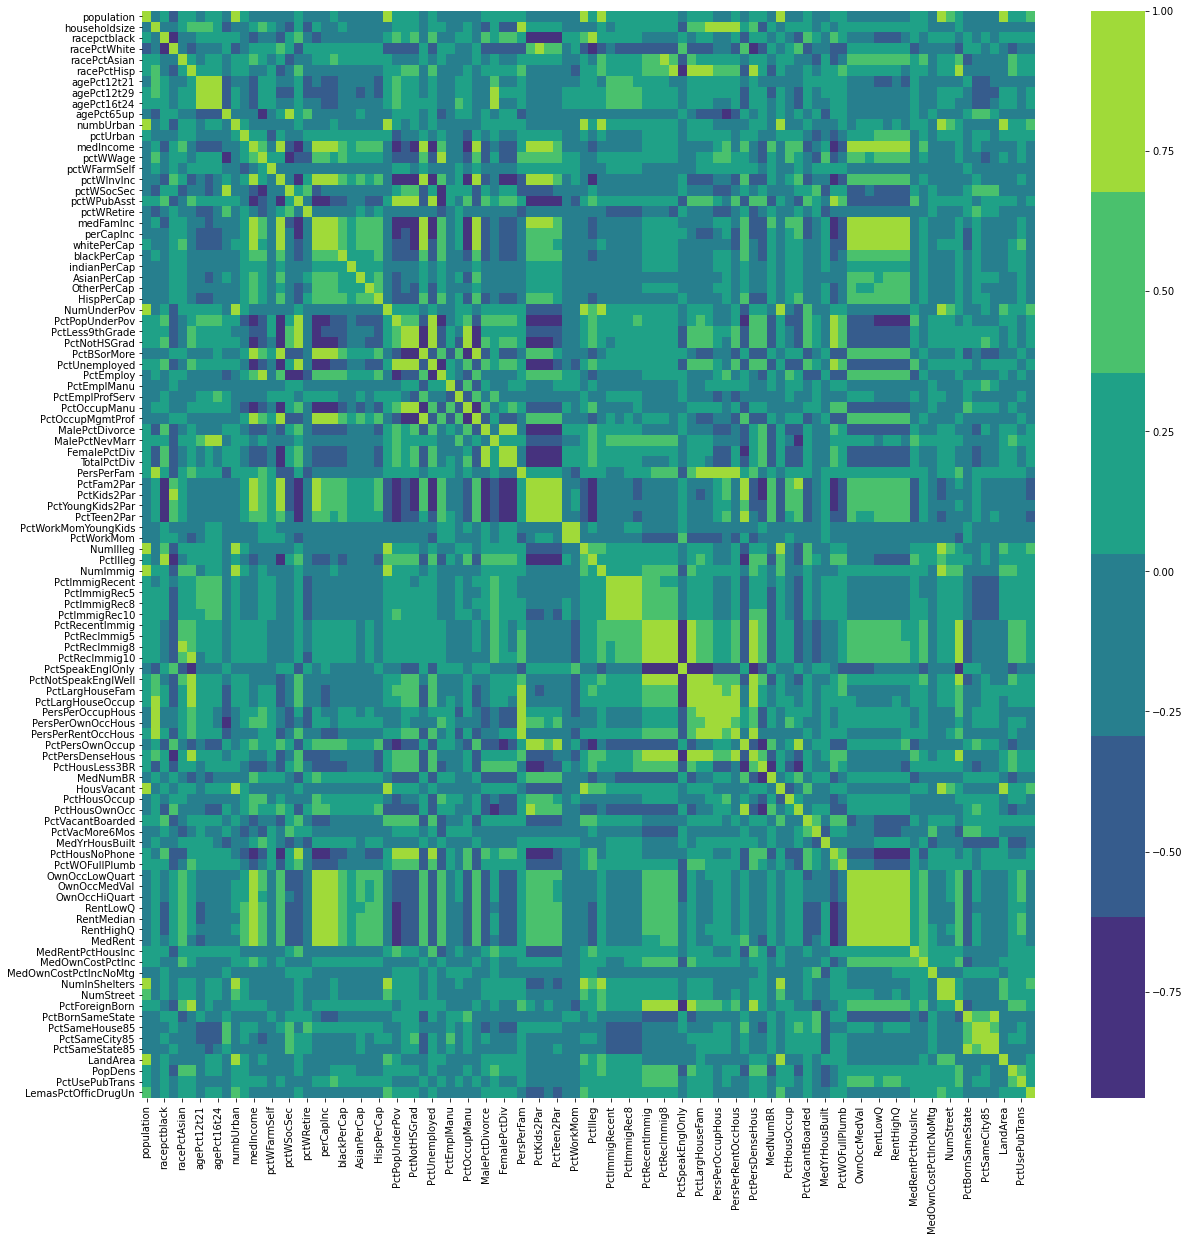

In [17]:
# Plot the correlation matrix for all predictive features

plt.figure(figsize=(20, 20))

corrMatrix = x_comm.iloc[:,5:].corr()
sns.heatmap(corrMatrix, cmap=sns.color_palette("viridis"))

# (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean.

In [18]:
# Calculate std. deviation and mean separately and then divide to get the CV

x_comm_std = np.std(x_comm).to_frame(name='std')
x_comm_mean = np.mean(x_comm).to_frame(name='mean')

x_comm_cov = pd.concat([x_comm_std,x_comm_mean],axis=1)
x_comm_cov['cov'] = x_comm_cov['std']/x_comm_cov['mean']
x_comm_cov.iloc[2:]

std      mean       cov
population           0.126874  0.057593  2.202950
householdsize        0.163676  0.463395  0.353210
racepctblack         0.253379  0.179629  1.410567
racePctWhite         0.243978  0.753716  0.323700
racePctAsian         0.208825  0.153681  1.358821
...                       ...       ...       ...
PctSameState85       0.198171  0.651530  0.304163
LandArea             0.109432  0.065231  1.677611
PopDens              0.203041  0.232854  0.871968
PctUsePubTrans       0.228997  0.161685  1.416317
LemasPctOfficDrugUn  0.240268  0.094052  2.554625

[100 rows x 3 columns]

# (e) Pick |128^0.5| features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [19]:
# Select the 11 features with highest CV

x_comm_cov_sorted_top_11 = x_comm_cov.iloc[2:].sort_values(by=['cov'],ascending=False).head(11)['cov'].to_frame(name='cov')
x_comm_cov_sorted_top_11

cov
NumStreet            4.406597
NumInShelters        3.484607
NumIlleg             2.993446
NumImmig             2.899770
LemasPctOfficDrugUn  2.554625
NumUnderPov          2.304392
population           2.202950
numbUrban            2.001242
HousVacant           1.958288
LandArea             1.677611
racePctHisp          1.613873

In [20]:
# Combine y_train and y_test 

y_comm = pd.concat([y_train,y_test],axis=0,ignore_index=True)
y_comm

ViolentCrimesPerPop
0                    0.20
1                    0.67
2                    0.43
3                    0.12
4                    0.03
...                   ...
1989                 0.09
1990                 0.45
1991                 0.23
1992                 0.19
1993                 0.48

[1994 rows x 1 columns]

In [21]:
# Filter the dataframe for these top 11 features along with their labels

df_comm_selected = pd.DataFrame()

for i in x_comm_cov_sorted_top_11.index:
    df_comm_selected = pd.concat([df_comm_selected,x_comm[[i]]],axis=1)
    
df_comm_selected = pd.concat([df_comm_selected,y_comm[['ViolentCrimesPerPop']]],axis=1)

df_comm_selected

NumStreet  NumInShelters  NumIlleg  NumImmig  LemasPctOfficDrugUn  \
0          0.00           0.04      0.04      0.03                 0.32   
1          0.00           0.00      0.00      0.01                 0.00   
2          0.00           0.00      0.01      0.00                 0.00   
3          0.00           0.00      0.03      0.02                 0.00   
4          0.00           0.00      0.00      0.00                 0.00   
...         ...            ...       ...       ...                  ...   
1989       0.00           0.00      0.00      0.01                 0.00   
1990       0.00           0.01      0.03      0.05                 0.00   
1991       0.02           0.06      0.13      0.06                 0.91   
1992       0.01           0.04      0.02      0.06                 0.22   
1993       0.08           0.08      0.11      0.20                 1.00   

      NumUnderPov  population  numbUrban  HousVacant  LandArea  racePctHisp  \
0            0.08        0.19       0.20        0.21      0.12         0.17   
1            0.01        0.00       0.02        0.02      0.02         0.07   
2            0.01        0.00       0.00        0.01      0.01         0.04   
3            0.01        0.04       0.06        0.01      0.02         0.10   
4            0.00        0.01       0.02        0.01      0.04         0.05   
...           ...         ...        ...         ...       ...          ...   
1989         0.01        0.01       0.03        0.02      0.01         0.16   
1990         0.04        0.05       0.06        0.03      0.02         0.32   
1991         0.12        0.16       0.17        0.21      0.08         0.25   
1992         0.03        0.08       0.09        0.05      0.03         0.10   
1993         0.16        0.20       0.21        0.12      0.11         0.77   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[1994 rows x 12 columns]

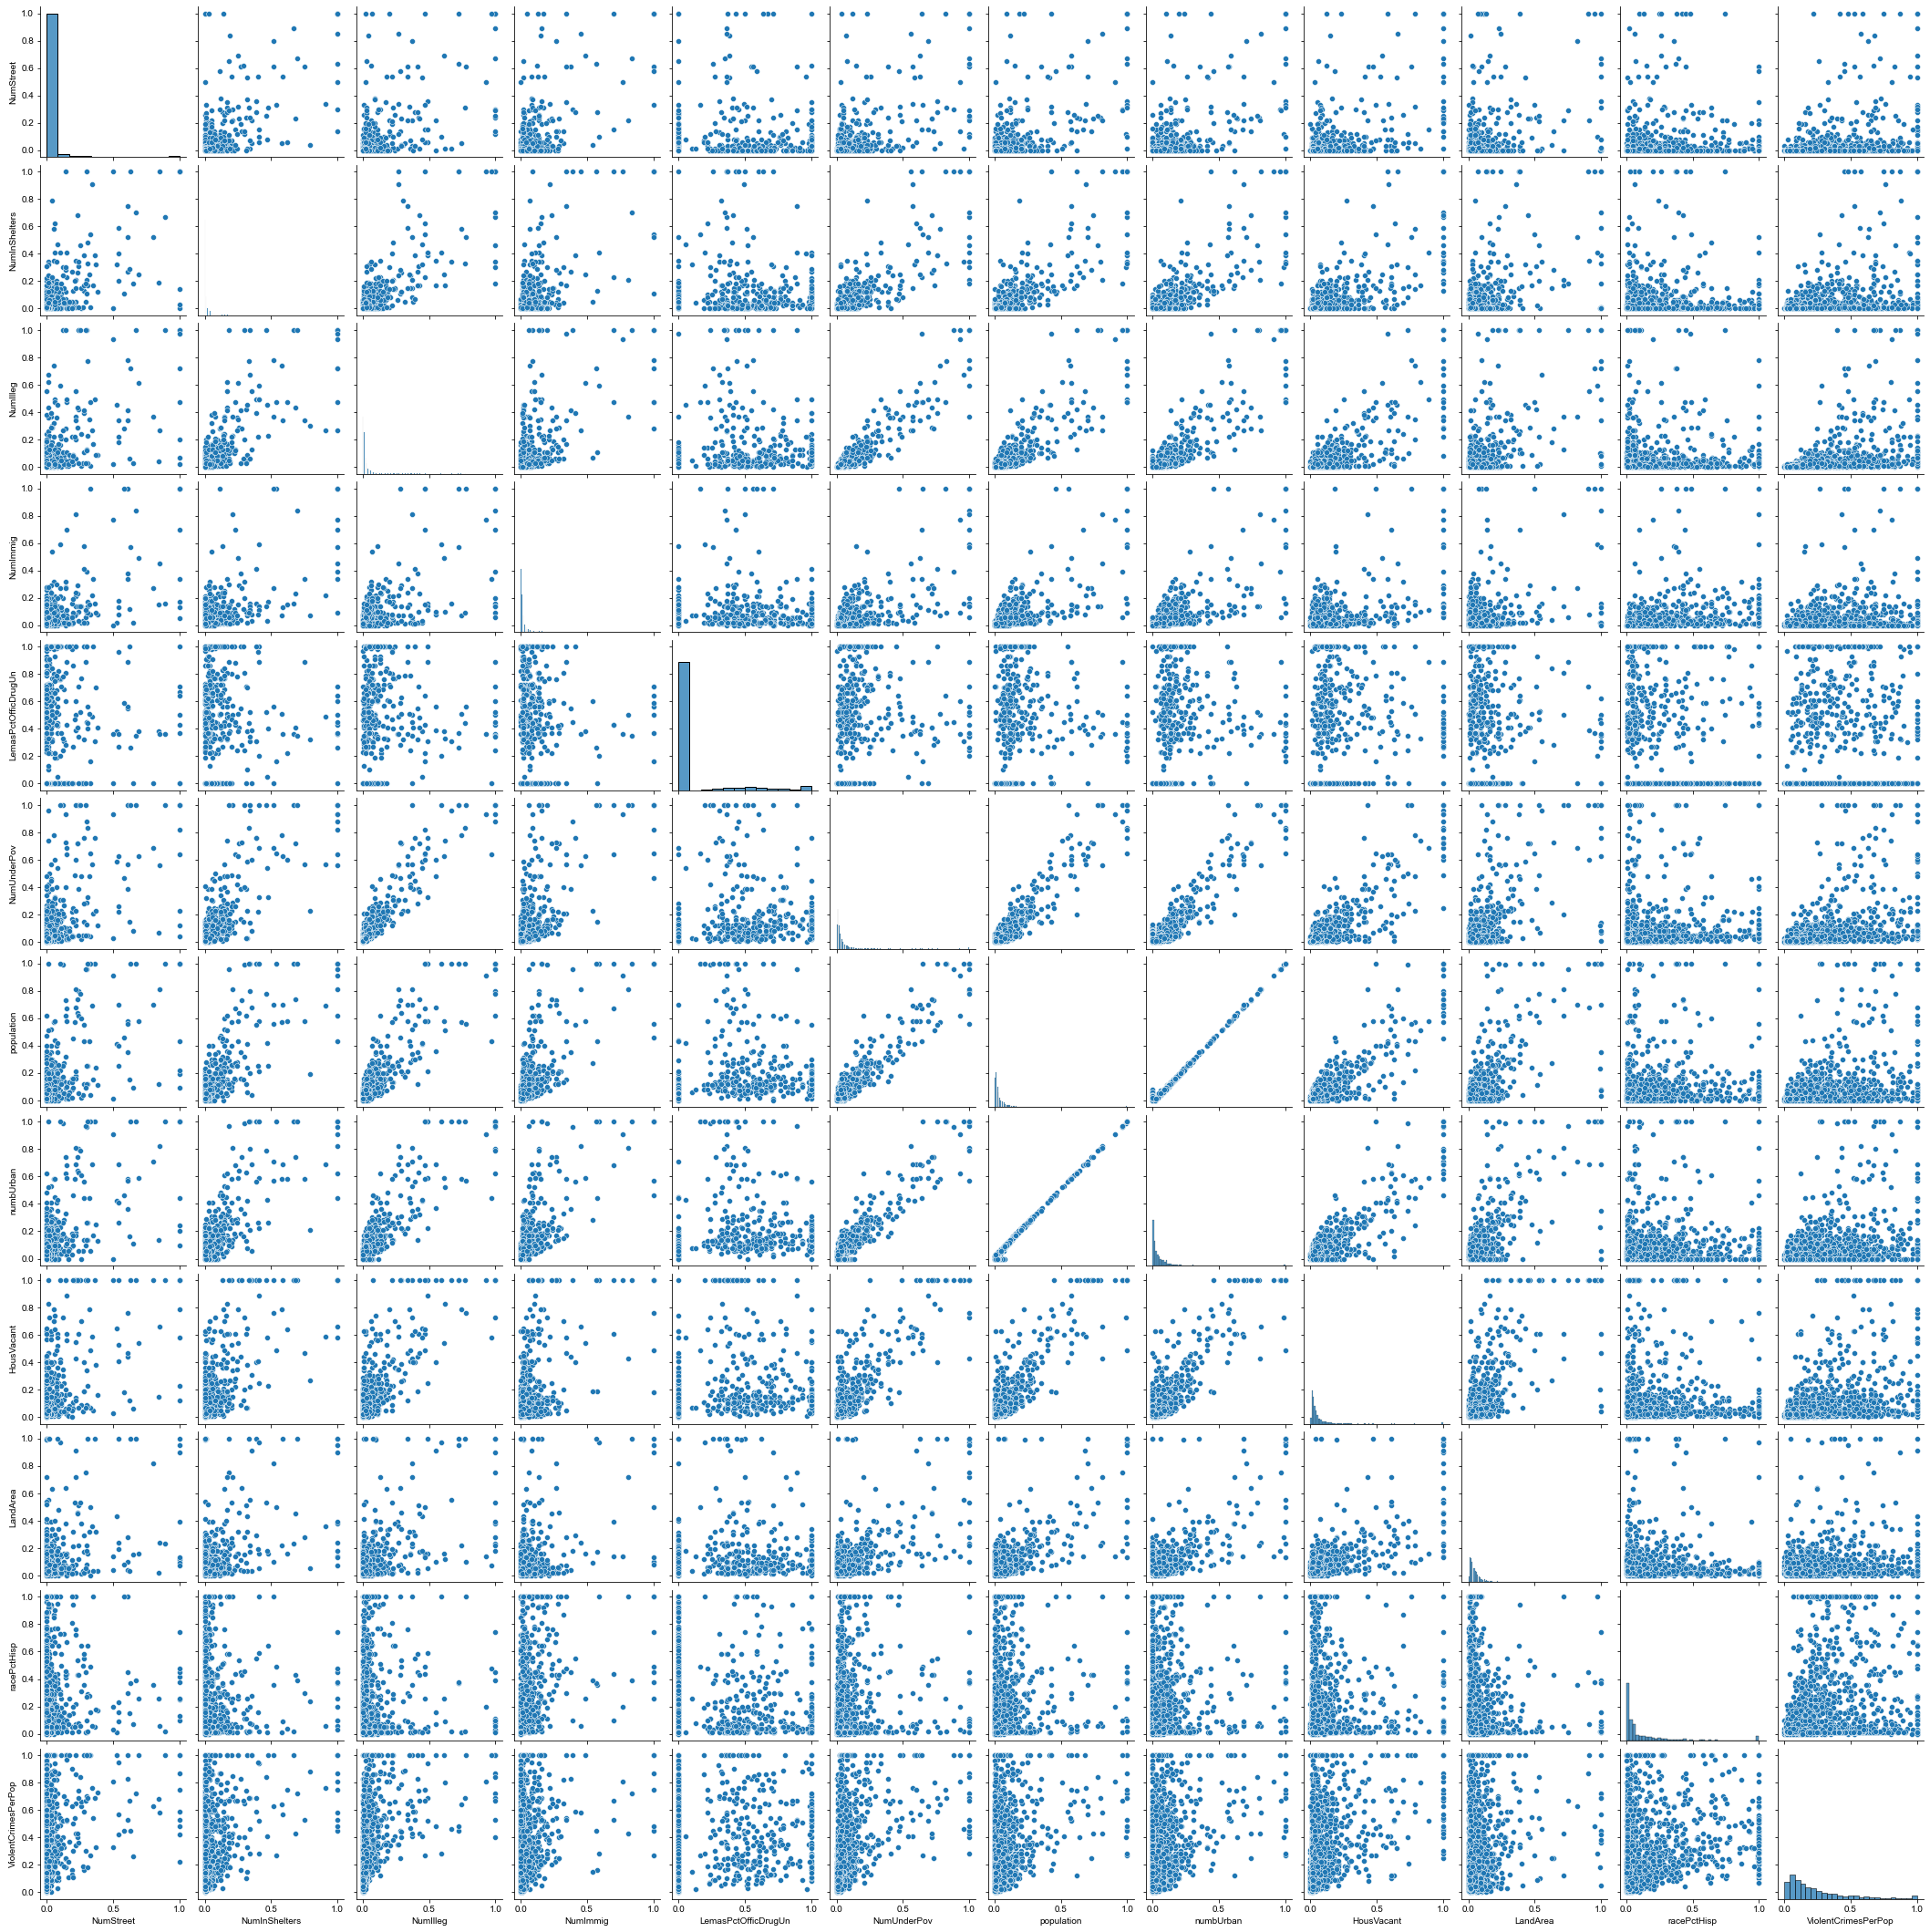

In [22]:
# Using the pairplot function of the seaborn library, plot graphs between all pairs of variables

sns.pairplot(df_comm_selected, palette='mako')
sns.set(rc = {'figure.figsize':(20,20)})

It is difficult to judge the significance of these features by seeing the scatterplot, because the dots are too dense to see the pattern. 
But by a rough observation, among all high cv features, we can see high correlations between 'NumUnderPov', 'NumUrban' and 'Population'.

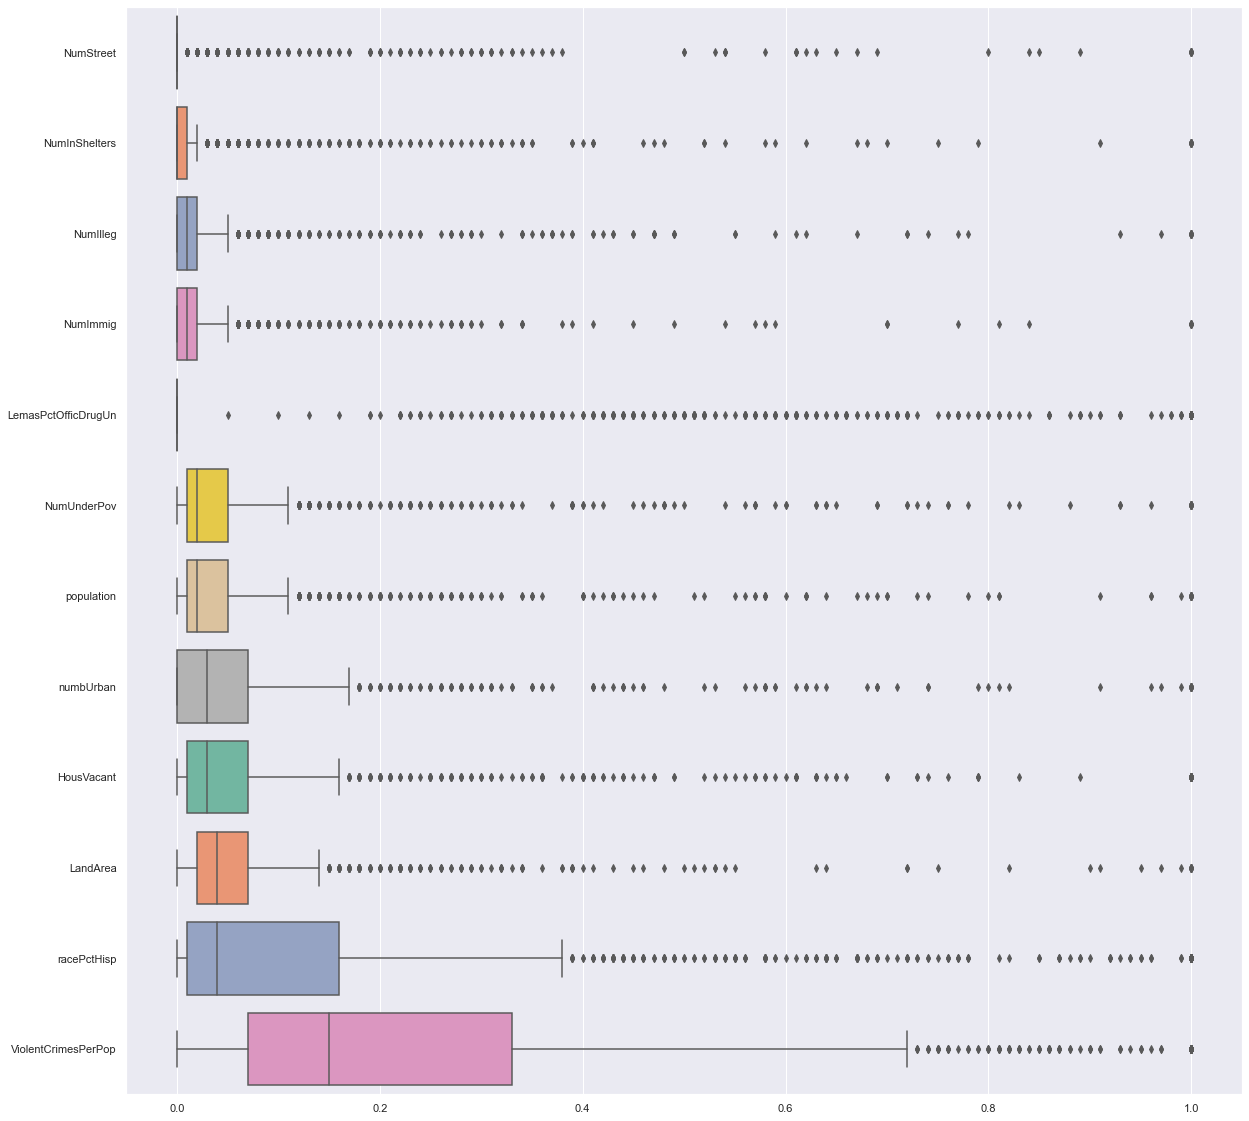

In [23]:
# Using the boxplot function of the seaborn library, plot a boxplot for all variables

sns.boxplot(data = df_comm_selected, orient="h", palette="Set2")
sns.set(rc = {'figure.figsize':(15,15)})

# (f) Fit a linear model using least squares to the training set and report the test error.

In [24]:
lin_reg = LinearRegression().fit(x_train.iloc[:,5:], y_train)
y_test_pred = lin_reg.predict(x_test.iloc[:,5:])

print("Test Mean Square Error: ", mean_squared_error(y_test, y_test_pred))
print('\n')
print("R^2 Score :", lin_reg.score(x_test.iloc[:,5:], y_test))

Test Mean Square Error:  0.017844546218641438


R^2 Score : 0.6247622031491245


# (g) Fit a ridge regression model on the training set, with lambda chosen by cross-validation. Report the test error obtained.

In [25]:
# CV to choose best alpha

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

ridge_reg = RidgeCV(alphas=alphas,cv=5).fit(x_train.iloc[:,5:], y_train)

best_alpha = ridge_reg.alpha_

print("Best alpha :", best_alpha)

Best alpha : 1.0


In [26]:
# Fitting the model with the best alpha on the train data

ridge_reg = Ridge(alpha=best_alpha).fit(x_train.iloc[:,5:], y_train)
y_test_pred = ridge_reg.predict(x_test.iloc[:,5:])

print("Test Mean Square Error: ", mean_squared_error(y_test, y_test_pred))
print('\n')
print("R^2 Score :", ridge_reg.score(x_test.iloc[:,5:], y_test))

Test Mean Square Error:  0.017502183485907406


R^2 Score : 0.6319614580912738


# (h) Fit a LASSO model on the training set, with lambda chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [27]:
# CV to choose best alpha

warnings.filterwarnings('ignore')

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

lasso_reg = LassoCV(alphas=alphas,cv=5).fit(x_train.iloc[:,5:], y_train)

best_alpha = lasso_reg.alpha_

print("Best alpha :", best_alpha)

Best alpha : 0.0001


In [28]:
# Fitting the model with the best alpha on the train data

lasso_reg = Lasso(alpha=best_alpha).fit(x_train.iloc[:,5:], y_train)
y_test_pred = lasso_reg.predict(x_test.iloc[:,5:])

print("Test Mean Square Error: ", mean_squared_error(y_test, y_test_pred))
print('\n')
print("R^2 Score :", lasso_reg.score(x_test.iloc[:,5:], y_test))

Test Mean Square Error:  0.0175837008063847


R^2 Score : 0.6302472996382483


In [29]:
# Variables selected by the model

lasso_selected_variables = pd.DataFrame(data = lasso_reg.coef_[lasso_reg.coef_!=0], index = x_train.iloc[:,5:].columns[lasso_reg.coef_!=0], columns=['coeff'])
lasso_selected_variables

coeff
racepctblack         0.275386
racePctAsian        -0.014812
agePct12t21          0.078205
agePct12t29         -0.279278
agePct65up           0.011947
...                       ...
PctSameCity85        0.028105
LandArea             0.016662
PopDens              0.007534
PctUsePubTrans      -0.046077
LemasPctOfficDrugUn  0.009124

[67 rows x 1 columns]

In [30]:
warnings.filterwarnings('ignore')

# Perform standardization using the StandardScaler

std = StandardScaler()

x_train_std = std.fit_transform(x_train.iloc[:,5:])
x_test_std = std.transform(x_test.iloc[:,5:])


# CV to choose best alpha

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

lasso_reg = LassoCV(alphas=alphas,cv=5).fit(x_train_std, y_train)

best_alpha = lasso_reg.alpha_

print("Best alpha :", best_alpha)

Best alpha : 0.001


In [31]:
# Fitting the model with the best alpha on the train data

lasso_reg = Lasso(alpha=best_alpha).fit(x_train_std, y_train)
y_test_pred = lasso_reg.predict(x_test_std)

print("Test Mean Square Error: ", mean_squared_error(y_test, y_test_pred))
print('\n')
print("R^2 Score :", lasso_reg.score(x_test_std, y_test))

Test Mean Square Error:  0.017518514612687237


R^2 Score : 0.6316180447055887


In [32]:
# Variables selected by the model

lasso_selected_variables = pd.DataFrame(data = lasso_reg.coef_[lasso_reg.coef_!=0], index = x_train.iloc[:,5:].columns[lasso_reg.coef_!=0], columns=['coeff'])
lasso_selected_variables

coeff
population            -0.001318
racepctblack           0.067537
agePct12t21            0.005806
agePct12t29           -0.027356
pctUrban               0.015397
pctWWage              -0.009828
pctWFarmSelf           0.003414
pctWInvInc            -0.015813
pctWSocSec             0.005282
pctWPubAsst            0.003295
pctWRetire            -0.014889
whitePerCap           -0.004650
blackPerCap           -0.003123
indianPerCap          -0.005016
AsianPerCap            0.004814
OtherPerCap            0.003801
HispPerCap             0.002936
PctPopUnderPov        -0.021053
PctLess9thGrade       -0.000525
PctEmploy              0.015509
MalePctDivorce         0.016555
MalePctNevMarr         0.015152
FemalePctDiv          -0.001860
PctKids2Par           -0.041631
PctYoungKids2Par      -0.008788
PctTeen2Par           -0.000512
PctWorkMom            -0.020014
NumIlleg              -0.008321
PctIlleg               0.025803
NumImmig              -0.005985
PctImmigRec5          -0.001296
PctRecImmig10          0.004038
PctNotSpeakEnglWell   -0.001797
PctPersOwnOccup       -0.005150
PctPersDenseHous       0.033387
PctHousLess3BR         0.008890
HousVacant             0.018773
PctHousOccup          -0.011969
PctVacantBoarded       0.013829
PctVacMore6Mos        -0.009416
MedYrHousBuilt        -0.002194
PctWOFullPlumb        -0.003783
RentLowQ              -0.022783
MedRent                0.020069
MedRentPctHousInc      0.014781
MedOwnCostPctIncNoMtg -0.013903
NumInShelters          0.006623
NumStreet              0.017913
PctForeignBorn         0.004154
PctBornSameState      -0.000271
PctSameCity85          0.004439
LandArea               0.000780
PopDens                0.001238
PctUsePubTrans        -0.006508
LemasPctOfficDrugUn    0.002327

The test error for Lasso after standardizing the features is essentially the same as the test error for Lasso without standardizing the features. 
The features selected by both methods are almost the same for the most part.
This result is expected because the data has already been normalized before so it is redundant to perform standardization again.

# (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [33]:
warnings.filterwarnings('ignore')

# Perform standardization using the StandardScaler

std = StandardScaler()

x_train_std = std.fit_transform(x_train.iloc[:,5:])
x_test_std = std.transform(x_test.iloc[:,5:])

# CV to choose best M

lin_reg = LinearRegression()
train_mse_dict = {}

for m in range(1, x_train.iloc[:,5:].shape[1]+1):
    x_train_pca = PCA(n_components=m).fit_transform(x_train_std)
    
    train_mse_dict[m] = [-1 * (cross_val_score(lin_reg, x_train_pca, y_train, cv=5,
                                    scoring='neg_mean_squared_error').mean())]

print("Minimum train MSE out of all of them is:")

train_mses = []

for i in range(1,x_train.iloc[:,5:].shape[1]+1):
    train_mses.append(train_mse_dict[i][0])
    
print(np.min(train_mses))

print('\n')
print("m at which we got minimum train MSE is:")
best_m = np.argmin(train_mses)
print(best_m)

Minimum train MSE out of all of them is:
0.019183948186102067


m at which we got minimum train MSE is:
77


In [34]:
# Fitting the model with the best M on the train data

pca = PCA(n_components=best_m)

x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

lin_reg = LinearRegression().fit(x_train_pca, y_train)
y_test_pred = lin_reg.predict(x_test_pca)

print("Test Mean Square Error: ", mean_squared_error(y_test, y_test_pred))
print('\n')
print("R^2 Score :", lin_reg.score(x_test_pca, y_test))

Test Mean Square Error:  0.018130204958782713


R^2 Score : 0.6187553282760705


# (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine (the regularization term) using cross-validation.

In [35]:
# CV to choose best alpha

xgb_r_model = xgb.XGBRegressor(learning_rate = 0.1,max_depth=5,n_estimators=100,objective="reg:squarederror",eval_metric='rmse',n_jobs=-1)

params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}
grid_search = GridSearchCV(estimator=xgb_r_model, param_grid=params, cv=5)
grid_search.fit(x_train.iloc[:,5:], y_train)

best_alpha = grid_search.best_params_['alpha']

print("Best alpha :", best_alpha)

Best alpha : 1.0


In [36]:
# Fitting the model with the best alpha on the train data

xgb_r_model = xgb.XGBRegressor(alpha=best_alpha,learning_rate = 0.1,max_depth=5,n_estimators=100,objective="reg:squarederror",eval_metric='rmse',n_jobs=-1).fit(x_train.iloc[:,5:], y_train)
y_test_pred = xgb_r_model.predict(x_test.iloc[:,5:])

print("Test Mean Square Error: ", mean_squared_error(y_test, y_test_pred))
print('\n')
print("R^2 Score :", xgb_r_model.score(x_test.iloc[:,5:], y_test))

Test Mean Square Error:  0.01653266246700706


R^2 Score : 0.652348691628921


For selecting the model for this dataset, I would choose the XG boosting tree model since it has lowest test error (among all regressions).

# 2. Tree-Based Methods

# (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [37]:
# Read the input files into dataframes

df_1 = pd.read_csv("../data/aps_failure_training_set.csv", skiprows=20, na_values='na')
df_2 = pd.read_csv("../data/aps_failure_test_set.csv", skiprows=20, na_values='na')

df_aps = pd.concat([df_1,df_2],axis=0,ignore_index=True)
df_aps

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2       neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
75995   neg   81852     NaN  2.130706e+09   892.0     0.0     0.0     0.0   
75996   neg      18     0.0  5.200000e+01    46.0     8.0    26.0     0.0   
75997   neg   79636     NaN  1.670000e+03  1518.0     0.0     0.0     0.0   
75998   neg     110     NaN  3.600000e+01    32.0     0.0     0.0     0.0   
75999   neg       8     0.0  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0         0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1         0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2         0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3         0.0     0.0  ...      240.0      46.0      58.0      44.0      10.0   
4         0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0   
...       ...     ...  ...        ...       ...       ...       ...       ...   
75995     0.0     0.0  ...   632658.0  273242.0  510354.0  373918.0  349840.0   
75996     0.0     0.0  ...      266.0      44.0      46.0      14.0       2.0   
75997     0.0     0.0  ...   806832.0  449962.0  778826.0  581558.0  375498.0   
75998     0.0     0.0  ...      588.0     210.0     180.0     544.0    1004.0   
75999     0.0     0.0  ...       46.0      10.0      48.0      14.0      42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  
0      157956.0   73224.0      0.0     0.0     0.0  
1       81140.0   97576.0   1500.0     0.0     0.0  
2      158022.0   95128.0    514.0     0.0     0.0  
3           0.0       0.0      0.0     4.0    32.0  
4      311560.0  433954.0   1218.0     0.0     0.0  
...         ...       ...      ...     ...     ...  
75995  317840.0  960024.0  25566.0     0.0     0.0  
75996       0.0       0.0      0.0     0.0     0.0  
75997  222866.0  358934.0  19548.0     0.0     0.0  
75998    1338.0      74.0      0.0     0.0     0.0  
75999      46.0       0.0      0.0     0.0     0.0  

[76000 rows x 171 columns]

In [38]:
# Shift the target('class') variable to the end of the dataframe

cols_at_end = ['class']
df_aps = df_aps[[c for c in df_aps if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df_aps]]
df_aps

aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0       76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1       33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2       41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3          12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4       60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   
...       ...     ...           ...     ...     ...     ...     ...     ...   
75995   81852     NaN  2.130706e+09   892.0     0.0     0.0     0.0     0.0   
75996      18     0.0  5.200000e+01    46.0     8.0    26.0     0.0     0.0   
75997   79636     NaN  1.670000e+03  1518.0     0.0     0.0     0.0     0.0   
75998     110     NaN  3.600000e+01    32.0     0.0     0.0     0.0     0.0   
75999       8     0.0  6.000000e+00     4.0     2.0     2.0     0.0     0.0   

       ag_002  ag_003  ...    ee_003    ee_004    ee_005    ee_006    ee_007  \
0         0.0     0.0  ...  493384.0  721044.0  469792.0  339156.0  157956.0   
1         0.0     0.0  ...  178064.0  293306.0  245416.0  133654.0   81140.0   
2         0.0     0.0  ...  159812.0  423992.0  409564.0  320746.0  158022.0   
3         0.0   318.0  ...      46.0      58.0      44.0      10.0       0.0   
4         0.0     0.0  ...  229790.0  405298.0  347188.0  286954.0  311560.0   
...       ...     ...  ...       ...       ...       ...       ...       ...   
75995     0.0     0.0  ...  273242.0  510354.0  373918.0  349840.0  317840.0   
75996     0.0     0.0  ...      44.0      46.0      14.0       2.0       0.0   
75997     0.0     0.0  ...  449962.0  778826.0  581558.0  375498.0  222866.0   
75998     0.0     0.0  ...     210.0     180.0     544.0    1004.0    1338.0   
75999     0.0     0.0  ...      10.0      48.0      14.0      42.0      46.0   

         ee_008   ee_009  ef_000  eg_000  class  
0       73224.0      0.0     0.0     0.0    neg  
1       97576.0   1500.0     0.0     0.0    neg  
2       95128.0    514.0     0.0     0.0    neg  
3           0.0      0.0     4.0    32.0    neg  
4      433954.0   1218.0     0.0     0.0    neg  
...         ...      ...     ...     ...    ...  
75995  960024.0  25566.0     0.0     0.0    neg  
75996       0.0      0.0     0.0     0.0    neg  
75997  358934.0  19548.0     0.0     0.0    neg  
75998      74.0      0.0     0.0     0.0    neg  
75999       0.0      0.0     0.0     0.0    neg  

[76000 rows x 171 columns]

In [39]:
# Make the target variable numeric (pos-1 , neg-0)

df_aps['class'] = np.where(df_aps['class']=='pos',1,0)
df_aps

aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0       76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1       33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2       41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3          12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4       60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   
...       ...     ...           ...     ...     ...     ...     ...     ...   
75995   81852     NaN  2.130706e+09   892.0     0.0     0.0     0.0     0.0   
75996      18     0.0  5.200000e+01    46.0     8.0    26.0     0.0     0.0   
75997   79636     NaN  1.670000e+03  1518.0     0.0     0.0     0.0     0.0   
75998     110     NaN  3.600000e+01    32.0     0.0     0.0     0.0     0.0   
75999       8     0.0  6.000000e+00     4.0     2.0     2.0     0.0     0.0   

       ag_002  ag_003  ...    ee_003    ee_004    ee_005    ee_006    ee_007  \
0         0.0     0.0  ...  493384.0  721044.0  469792.0  339156.0  157956.0   
1         0.0     0.0  ...  178064.0  293306.0  245416.0  133654.0   81140.0   
2         0.0     0.0  ...  159812.0  423992.0  409564.0  320746.0  158022.0   
3         0.0   318.0  ...      46.0      58.0      44.0      10.0       0.0   
4         0.0     0.0  ...  229790.0  405298.0  347188.0  286954.0  311560.0   
...       ...     ...  ...       ...       ...       ...       ...       ...   
75995     0.0     0.0  ...  273242.0  510354.0  373918.0  349840.0  317840.0   
75996     0.0     0.0  ...      44.0      46.0      14.0       2.0       0.0   
75997     0.0     0.0  ...  449962.0  778826.0  581558.0  375498.0  222866.0   
75998     0.0     0.0  ...     210.0     180.0     544.0    1004.0    1338.0   
75999     0.0     0.0  ...      10.0      48.0      14.0      42.0      46.0   

         ee_008   ee_009  ef_000  eg_000  class  
0       73224.0      0.0     0.0     0.0      0  
1       97576.0   1500.0     0.0     0.0      0  
2       95128.0    514.0     0.0     0.0      0  
3           0.0      0.0     4.0    32.0      0  
4      433954.0   1218.0     0.0     0.0      0  
...         ...      ...     ...     ...    ...  
75995  960024.0  25566.0     0.0     0.0      0  
75996       0.0      0.0     0.0     0.0      0  
75997  358934.0  19548.0     0.0     0.0      0  
75998      74.0      0.0     0.0     0.0      0  
75999       0.0      0.0     0.0     0.0      0  

[76000 rows x 171 columns]

# (b) Data Preparation

This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

# i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

Types of techniques that are usually used for dealing with data with missing values:-
Single Imputation - 
Single estimate of the missing value. Popular because it is conceptually simple and because the resulting sample has the same number of observations as the full data set. However some imputation methods result in biased parameter estimates, such as means, correlations, and regression coefficients and all single imputation methods underestimate standard errors.

1. Imputation using mean/median values
2. Imputation using mode/(zero or constant) values
3. Substitution
4. Hot Deck Imputation
5. Cold Deck Imputation
6. Regression Imputation
7. Stochastic Regression Imputation
8. Interpolation and Extrapolation
9. Imputation using KNN

Multiple Imputation -
Comes up with multiple estimates. Two of the methods listed above work as the imputation methods in multiple imputation– hot deck and stochastic regression. Because these two methods have a random component, the multiple estimates are slightly different. This re-introduces some variation that your software can incorporate in order to give your model accurate estimates of standard error. Much better than a single imputation as it measures the uncertainty of the missing values in a better way.

1. Imputation Using Multivariate Imputation by Chained Equation (MICE)

The MICE approach to deal with the missing values is very flexible and can handle different variables of different data types (ie., continuous or binary) as well as complexities such as bounds or survey skip patterns. This type of imputation works by filling the missing data multiple times.
I will be using a more sophisticated approach of multivariate imputation- the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. This following implementation of IterativeImputer is inspired by the R MICE package. We are modifying it for multiple estimates by applying it repeatedly to the same dataset with different random seeds. 

In [40]:
# Calculate the missing percent proportion for each column 

missing_percent = df_aps.apply(lambda x: (x.isna().sum())/len(x),axis = 0)
missing_percent[missing_percent.values!=0]        

ab_000    0.772263
ac_000    0.056066
ad_000    0.247921
ae_000    0.041974
af_000    0.041974
            ...   
ee_007    0.011355
ee_008    0.011355
ee_009    0.011355
ef_000    0.045868
eg_000    0.045855
Length: 169, dtype: float64

In [41]:
# Impute the missing data

it_imp = IterativeImputer(max_iter=10,sample_posterior=True,min_value=0,verbose=2,random_state=100)

df_aps_final = it_imp.fit_transform(df_aps)
df_aps_final

[IterativeImputer] Completing matrix with shape (76000, 171)
[IterativeImputer] Ending imputation round 1/10, elapsed time 211.11
[IterativeImputer] Ending imputation round 2/10, elapsed time 444.02
[IterativeImputer] Ending imputation round 3/10, elapsed time 672.53
[IterativeImputer] Ending imputation round 4/10, elapsed time 901.71
[IterativeImputer] Ending imputation round 5/10, elapsed time 1127.29
[IterativeImputer] Ending imputation round 6/10, elapsed time 1351.86
[IterativeImputer] Ending imputation round 7/10, elapsed time 1579.67
[IterativeImputer] Ending imputation round 8/10, elapsed time 1803.19
[IterativeImputer] Ending imputation round 9/10, elapsed time 2025.61
[IterativeImputer] Ending imputation round 10/10, elapsed time 2243.70


array([[7.66980000e+04, 5.57454019e+01, 2.13070644e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.30580000e+04, 1.35609828e+02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.10400000e+04, 5.02409383e+01, 2.28000000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.96360000e+04, 6.44898148e+01, 1.67000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10000000e+02, 1.13971224e+02, 3.60000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [42]:
cols = df_aps.columns

df_aps_final = pd.DataFrame(df_aps_final, columns = cols)
df_aps_final

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0      76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1      33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2      41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3         12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4      60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...        ...         ...           ...            ...     ...     ...   
75995  81852.0  119.662509  2.130706e+09     892.000000     0.0     0.0   
75996     18.0    0.000000  5.200000e+01      46.000000     8.0    26.0   
75997  79636.0   64.489815  1.670000e+03    1518.000000     0.0     0.0   
75998    110.0  113.971224  3.600000e+01      32.000000     0.0     0.0   
75999      8.0    0.000000  6.000000e+00       4.000000     2.0     2.0   

       ag_000  ag_001  ag_002  ag_003  ...    ee_003    ee_004    ee_005  \
0         0.0     0.0     0.0     0.0  ...  493384.0  721044.0  469792.0   
1         0.0     0.0     0.0     0.0  ...  178064.0  293306.0  245416.0   
2         0.0     0.0     0.0     0.0  ...  159812.0  423992.0  409564.0   
3         0.0     0.0     0.0   318.0  ...      46.0      58.0      44.0   
4         0.0     0.0     0.0     0.0  ...  229790.0  405298.0  347188.0   
...       ...     ...     ...     ...  ...       ...       ...       ...   
75995     0.0     0.0     0.0     0.0  ...  273242.0  510354.0  373918.0   
75996     0.0     0.0     0.0     0.0  ...      44.0      46.0      14.0   
75997     0.0     0.0     0.0     0.0  ...  449962.0  778826.0  581558.0   
75998     0.0     0.0     0.0     0.0  ...     210.0     180.0     544.0   
75999     0.0     0.0     0.0     0.0  ...      10.0      48.0      14.0   

         ee_006    ee_007    ee_008   ee_009  ef_000  eg_000  class  
0      339156.0  157956.0   73224.0      0.0     0.0     0.0    0.0  
1      133654.0   81140.0   97576.0   1500.0     0.0     0.0    0.0  
2      320746.0  158022.0   95128.0    514.0     0.0     0.0    0.0  
3          10.0       0.0       0.0      0.0     4.0    32.0    0.0  
4      286954.0  311560.0  433954.0   1218.0     0.0     0.0    0.0  
...         ...       ...       ...      ...     ...     ...    ...  
75995  349840.0  317840.0  960024.0  25566.0     0.0     0.0    0.0  
75996       2.0       0.0       0.0      0.0     0.0     0.0    0.0  
75997  375498.0  222866.0  358934.0  19548.0     0.0     0.0    0.0  
75998    1004.0    1338.0      74.0      0.0     0.0     0.0    0.0  
75999      42.0      46.0       0.0      0.0     0.0     0.0    0.0  

[76000 rows x 171 columns]

# ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [43]:
# Split the data frame into train and test

df_aps_train = df_aps_final.iloc[:60000]

df_aps_test = df_aps_final.iloc[60000:].reset_index()
df_aps_test.drop('index',axis=1,inplace=True)

df_aps_train
# df_aps_test

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0       76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1       33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2       41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3          12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4       60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...         ...         ...           ...            ...     ...     ...   
59995  153002.0  110.008832  6.640000e+02     186.000000     0.0     0.0   
59996    2286.0   71.143877  2.130707e+09     224.000000     0.0     0.0   
59997     112.0    0.000000  2.130706e+09      18.000000     0.0     0.0   
59998   80292.0   97.978511  2.130706e+09     494.000000     0.0     0.0   
59999   40222.0  137.370253  6.980000e+02     628.000000     0.0     0.0   

       ag_000  ag_001  ag_002  ag_003  ...    ee_003     ee_004     ee_005  \
0         0.0     0.0     0.0     0.0  ...  493384.0   721044.0   469792.0   
1         0.0     0.0     0.0     0.0  ...  178064.0   293306.0   245416.0   
2         0.0     0.0     0.0     0.0  ...  159812.0   423992.0   409564.0   
3         0.0     0.0     0.0   318.0  ...      46.0       58.0       44.0   
4         0.0     0.0     0.0     0.0  ...  229790.0   405298.0   347188.0   
...       ...     ...     ...     ...  ...       ...        ...        ...   
59995     0.0     0.0     0.0  2564.0  ...  566884.0  1290398.0  1218244.0   
59996     0.0     0.0     0.0     0.0  ...    6760.0    21126.0    68424.0   
59997     0.0     0.0     0.0     0.0  ...     386.0      452.0      144.0   
59998     0.0     0.0     0.0     0.0  ...  222654.0   347378.0   225724.0   
59999     0.0     0.0     0.0     0.0  ...  183200.0   344546.0   254068.0   

          ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  class  
0       339156.0  157956.0   73224.0       0.0     0.0     0.0    0.0  
1       133654.0   81140.0   97576.0    1500.0     0.0     0.0    0.0  
2       320746.0  158022.0   95128.0     514.0     0.0     0.0    0.0  
3           10.0       0.0       0.0       0.0     4.0    32.0    0.0  
4       286954.0  311560.0  433954.0    1218.0     0.0     0.0    0.0  
...          ...       ...       ...       ...     ...     ...    ...  
59995  1019768.0  717762.0  898642.0   28588.0     0.0     0.0    0.0  
59996      136.0       0.0       0.0       0.0     0.0     0.0    0.0  
59997      146.0    2622.0       0.0       0.0     0.0     0.0    0.0  
59998   194440.0  165070.0  802280.0  388422.0     0.0     0.0    0.0  
59999   225148.0  158304.0  170384.0     158.0     0.0     0.0    0.0  

[60000 rows x 171 columns]

In [44]:
# Split the train and test dataframes into x_train,y_train and x_test,y_test respectively

x_train = df_aps_train.iloc[:,0:len(df_aps_train.columns)-1]
y_train = df_aps_train.iloc[:,-1].to_frame()

x_test = df_aps_test.iloc[:,0:len(df_aps_test.columns)-1]
y_test = df_aps_test.iloc[:,-1].to_frame()

In [45]:
# Combine x_train and x_test 

x_aps = pd.concat([x_train,x_test],axis=0,ignore_index=True)
x_aps

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0      76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1      33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2      41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3         12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4      60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...        ...         ...           ...            ...     ...     ...   
75995  81852.0  119.662509  2.130706e+09     892.000000     0.0     0.0   
75996     18.0    0.000000  5.200000e+01      46.000000     8.0    26.0   
75997  79636.0   64.489815  1.670000e+03    1518.000000     0.0     0.0   
75998    110.0  113.971224  3.600000e+01      32.000000     0.0     0.0   
75999      8.0    0.000000  6.000000e+00       4.000000     2.0     2.0   

       ag_000  ag_001  ag_002  ag_003  ...     ee_002    ee_003    ee_004  \
0         0.0     0.0     0.0     0.0  ...  1240520.0  493384.0  721044.0   
1         0.0     0.0     0.0     0.0  ...   421400.0  178064.0  293306.0   
2         0.0     0.0     0.0     0.0  ...   277378.0  159812.0  423992.0   
3         0.0     0.0     0.0   318.0  ...      240.0      46.0      58.0   
4         0.0     0.0     0.0     0.0  ...   622012.0  229790.0  405298.0   
...       ...     ...     ...     ...  ...        ...       ...       ...   
75995     0.0     0.0     0.0     0.0  ...   632658.0  273242.0  510354.0   
75996     0.0     0.0     0.0     0.0  ...      266.0      44.0      46.0   
75997     0.0     0.0     0.0     0.0  ...   806832.0  449962.0  778826.0   
75998     0.0     0.0     0.0     0.0  ...      588.0     210.0     180.0   
75999     0.0     0.0     0.0     0.0  ...       46.0      10.0      48.0   

         ee_005    ee_006    ee_007    ee_008   ee_009  ef_000  eg_000  
0      469792.0  339156.0  157956.0   73224.0      0.0     0.0     0.0  
1      245416.0  133654.0   81140.0   97576.0   1500.0     0.0     0.0  
2      409564.0  320746.0  158022.0   95128.0    514.0     0.0     0.0  
3          44.0      10.0       0.0       0.0      0.0     4.0    32.0  
4      347188.0  286954.0  311560.0  433954.0   1218.0     0.0     0.0  
...         ...       ...       ...       ...      ...     ...     ...  
75995  373918.0  349840.0  317840.0  960024.0  25566.0     0.0     0.0  
75996      14.0       2.0       0.0       0.0      0.0     0.0     0.0  
75997  581558.0  375498.0  222866.0  358934.0  19548.0     0.0     0.0  
75998     544.0    1004.0    1338.0      74.0      0.0     0.0     0.0  
75999      14.0      42.0      46.0       0.0      0.0     0.0     0.0  

[76000 rows x 170 columns]

In [46]:
# Calculate std. deviation and mean separately and then divide to get the CV

x_aps_std = np.std(x_aps).to_frame(name='std')
x_aps_mean = np.mean(x_aps).to_frame(name='mean')

x_aps_cov = pd.concat([x_aps_std,x_aps_mean],axis=1)
x_aps_cov['cov'] = x_aps_cov['std']/x_aps_cov['mean']
x_aps_cov

std          mean         cov
aa_000  2.647349e+05  6.115976e+04    4.328579
ab_000  8.497090e+01  6.960678e+01    1.220727
ac_000  2.169771e+09  6.889724e+08    3.149285
ad_000  3.113866e+07  2.067833e+05  150.585900
ae_000  2.669662e+04  4.597256e+03    5.807076
...              ...           ...         ...
ee_007  1.698781e+06  3.478760e+05    4.883296
ee_008  4.699840e+05  1.420136e+05    3.309430
ee_009  7.691445e+04  1.177023e+04    6.534660
ef_000  2.414419e+03  4.212389e+02    5.731709
eg_000  1.078067e+04  1.893732e+03    5.692815

[170 rows x 3 columns]

# iii. Plot a correlation matrix for your features using pandas or any other tool.

<AxesSubplot:>

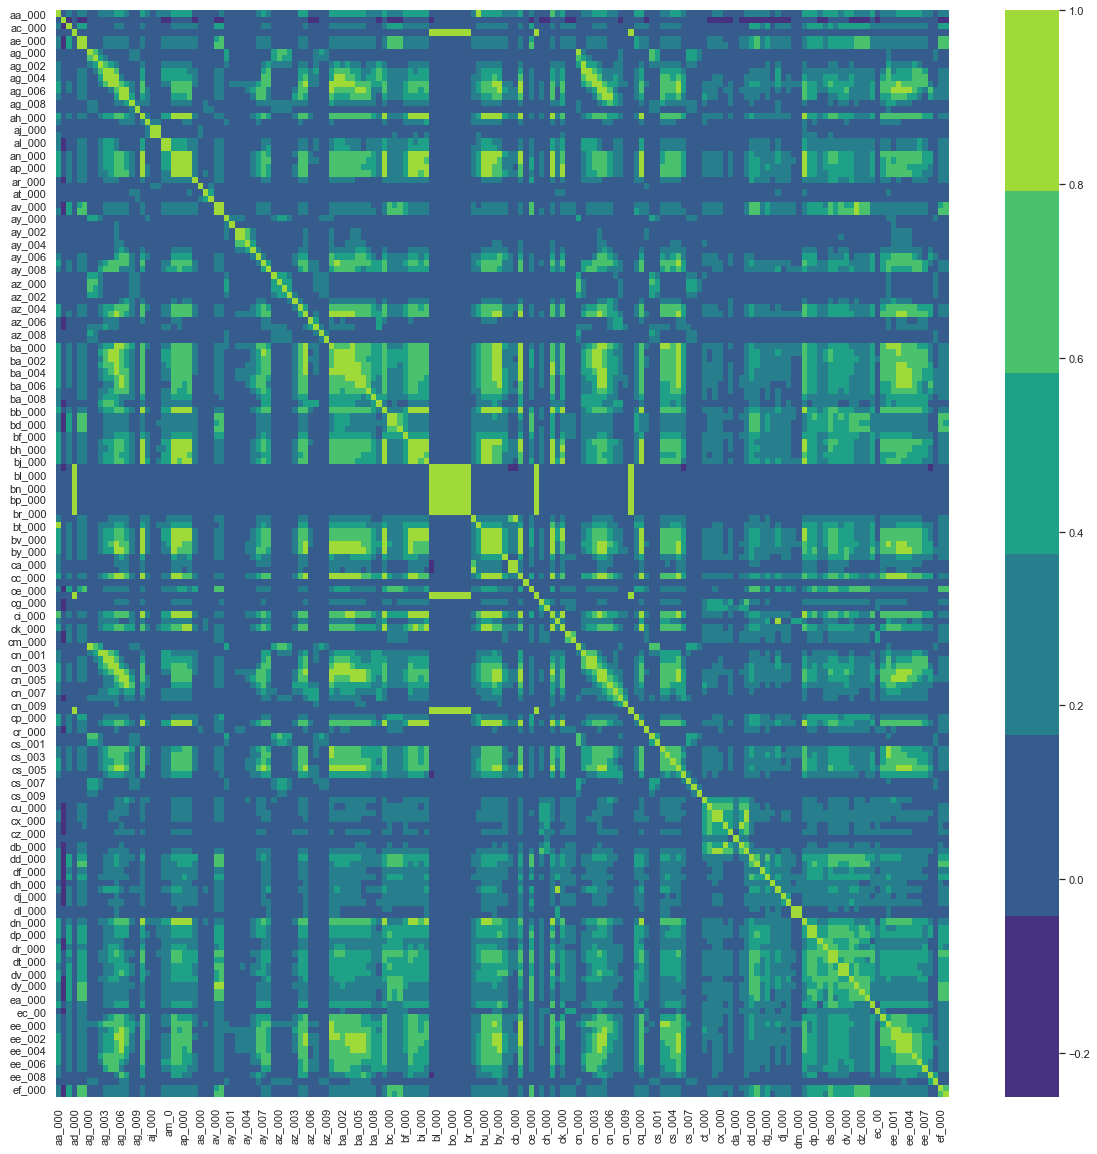

In [47]:
# Plot the correlation matrix for all features

plt.figure(figsize=(20, 20))

corrMatrix = x_aps.corr()
sns.heatmap(corrMatrix, cmap=sns.color_palette("viridis"))

# iv. Pick |170^0.5| features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [48]:
# Select the 13 features with highest CV

x_aps_cov_sorted_top_13 = x_aps_cov.sort_values(by=['cov'],ascending=False).head(13)['cov'].to_frame(name='cov')
x_aps_cov_sorted_top_13

cov
ad_000  150.585900
cf_000  149.174752
co_000  148.903106
cs_009   35.144124
au_000   29.725003
ay_004   26.382931
ay_001   25.796024
ay_002   24.372413
cn_009   21.960594
az_009   20.842365
ay_003   18.665607
as_000   18.066253
aj_000   17.226963

In [49]:
# Combine y_train and y_test 

y_aps = pd.concat([y_train,y_test],axis=0,ignore_index=True)
y_aps

class
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
75995    0.0
75996    0.0
75997    0.0
75998    0.0
75999    0.0

[76000 rows x 1 columns]

In [50]:
# Filter the dataframe for these top 13 features along with their labels

df_aps_selected = pd.DataFrame()

for i in x_aps_cov_sorted_top_13.index:
    df_aps_selected = pd.concat([df_aps_selected,x_aps[[i]]],axis=1)
    
df_aps_selected = pd.concat([df_aps_selected,y_aps[['class']]],axis=1)

df_aps_selected

ad_000        cf_000         co_000  cs_009  au_000   ay_004  \
0         280.000000       2.00000     220.000000     0.0     0.0      0.0   
1      739992.775141  708924.82933  616367.259092     0.0     0.0      0.0   
2         100.000000       0.00000       0.000000     0.0     0.0      0.0   
3          66.000000       2.00000       2.000000     0.0     0.0      0.0   
4         458.000000       0.00000     202.000000     0.0     0.0  42124.0   
...              ...           ...            ...     ...     ...      ...   
75995     892.000000       2.00000      42.000000     0.0     0.0      0.0   
75996      46.000000       2.00000       0.000000     0.0     0.0      0.0   
75997    1518.000000       2.00000     378.000000     0.0     0.0      0.0   
75998      32.000000       0.00000       0.000000     0.0     0.0      0.0   
75999       4.000000       0.00000       0.000000     0.0     0.0      0.0   

       ay_001  ay_002  cn_009  az_009  ay_003  as_000  aj_000  class  
0         0.0     0.0  1608.0     0.0     0.0     0.0     0.0    0.0  
1         0.0     0.0    56.0     0.0     0.0     0.0    68.0    0.0  
2         0.0     0.0    28.0     0.0     0.0     0.0     0.0    0.0  
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0  
4         0.0     0.0    86.0     0.0     0.0     0.0   226.0    0.0  
...       ...     ...     ...     ...     ...     ...     ...    ...  
75995     0.0     0.0  1328.0     0.0     0.0     0.0     0.0    0.0  
75996     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0  
75997     0.0     0.0   842.0     0.0     0.0     0.0     0.0    0.0  
75998     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0  
75999     0.0     0.0     0.0     0.0     0.0     0.0   472.0    0.0  

[76000 rows x 14 columns]

Time taken to plot: 260.503625869751


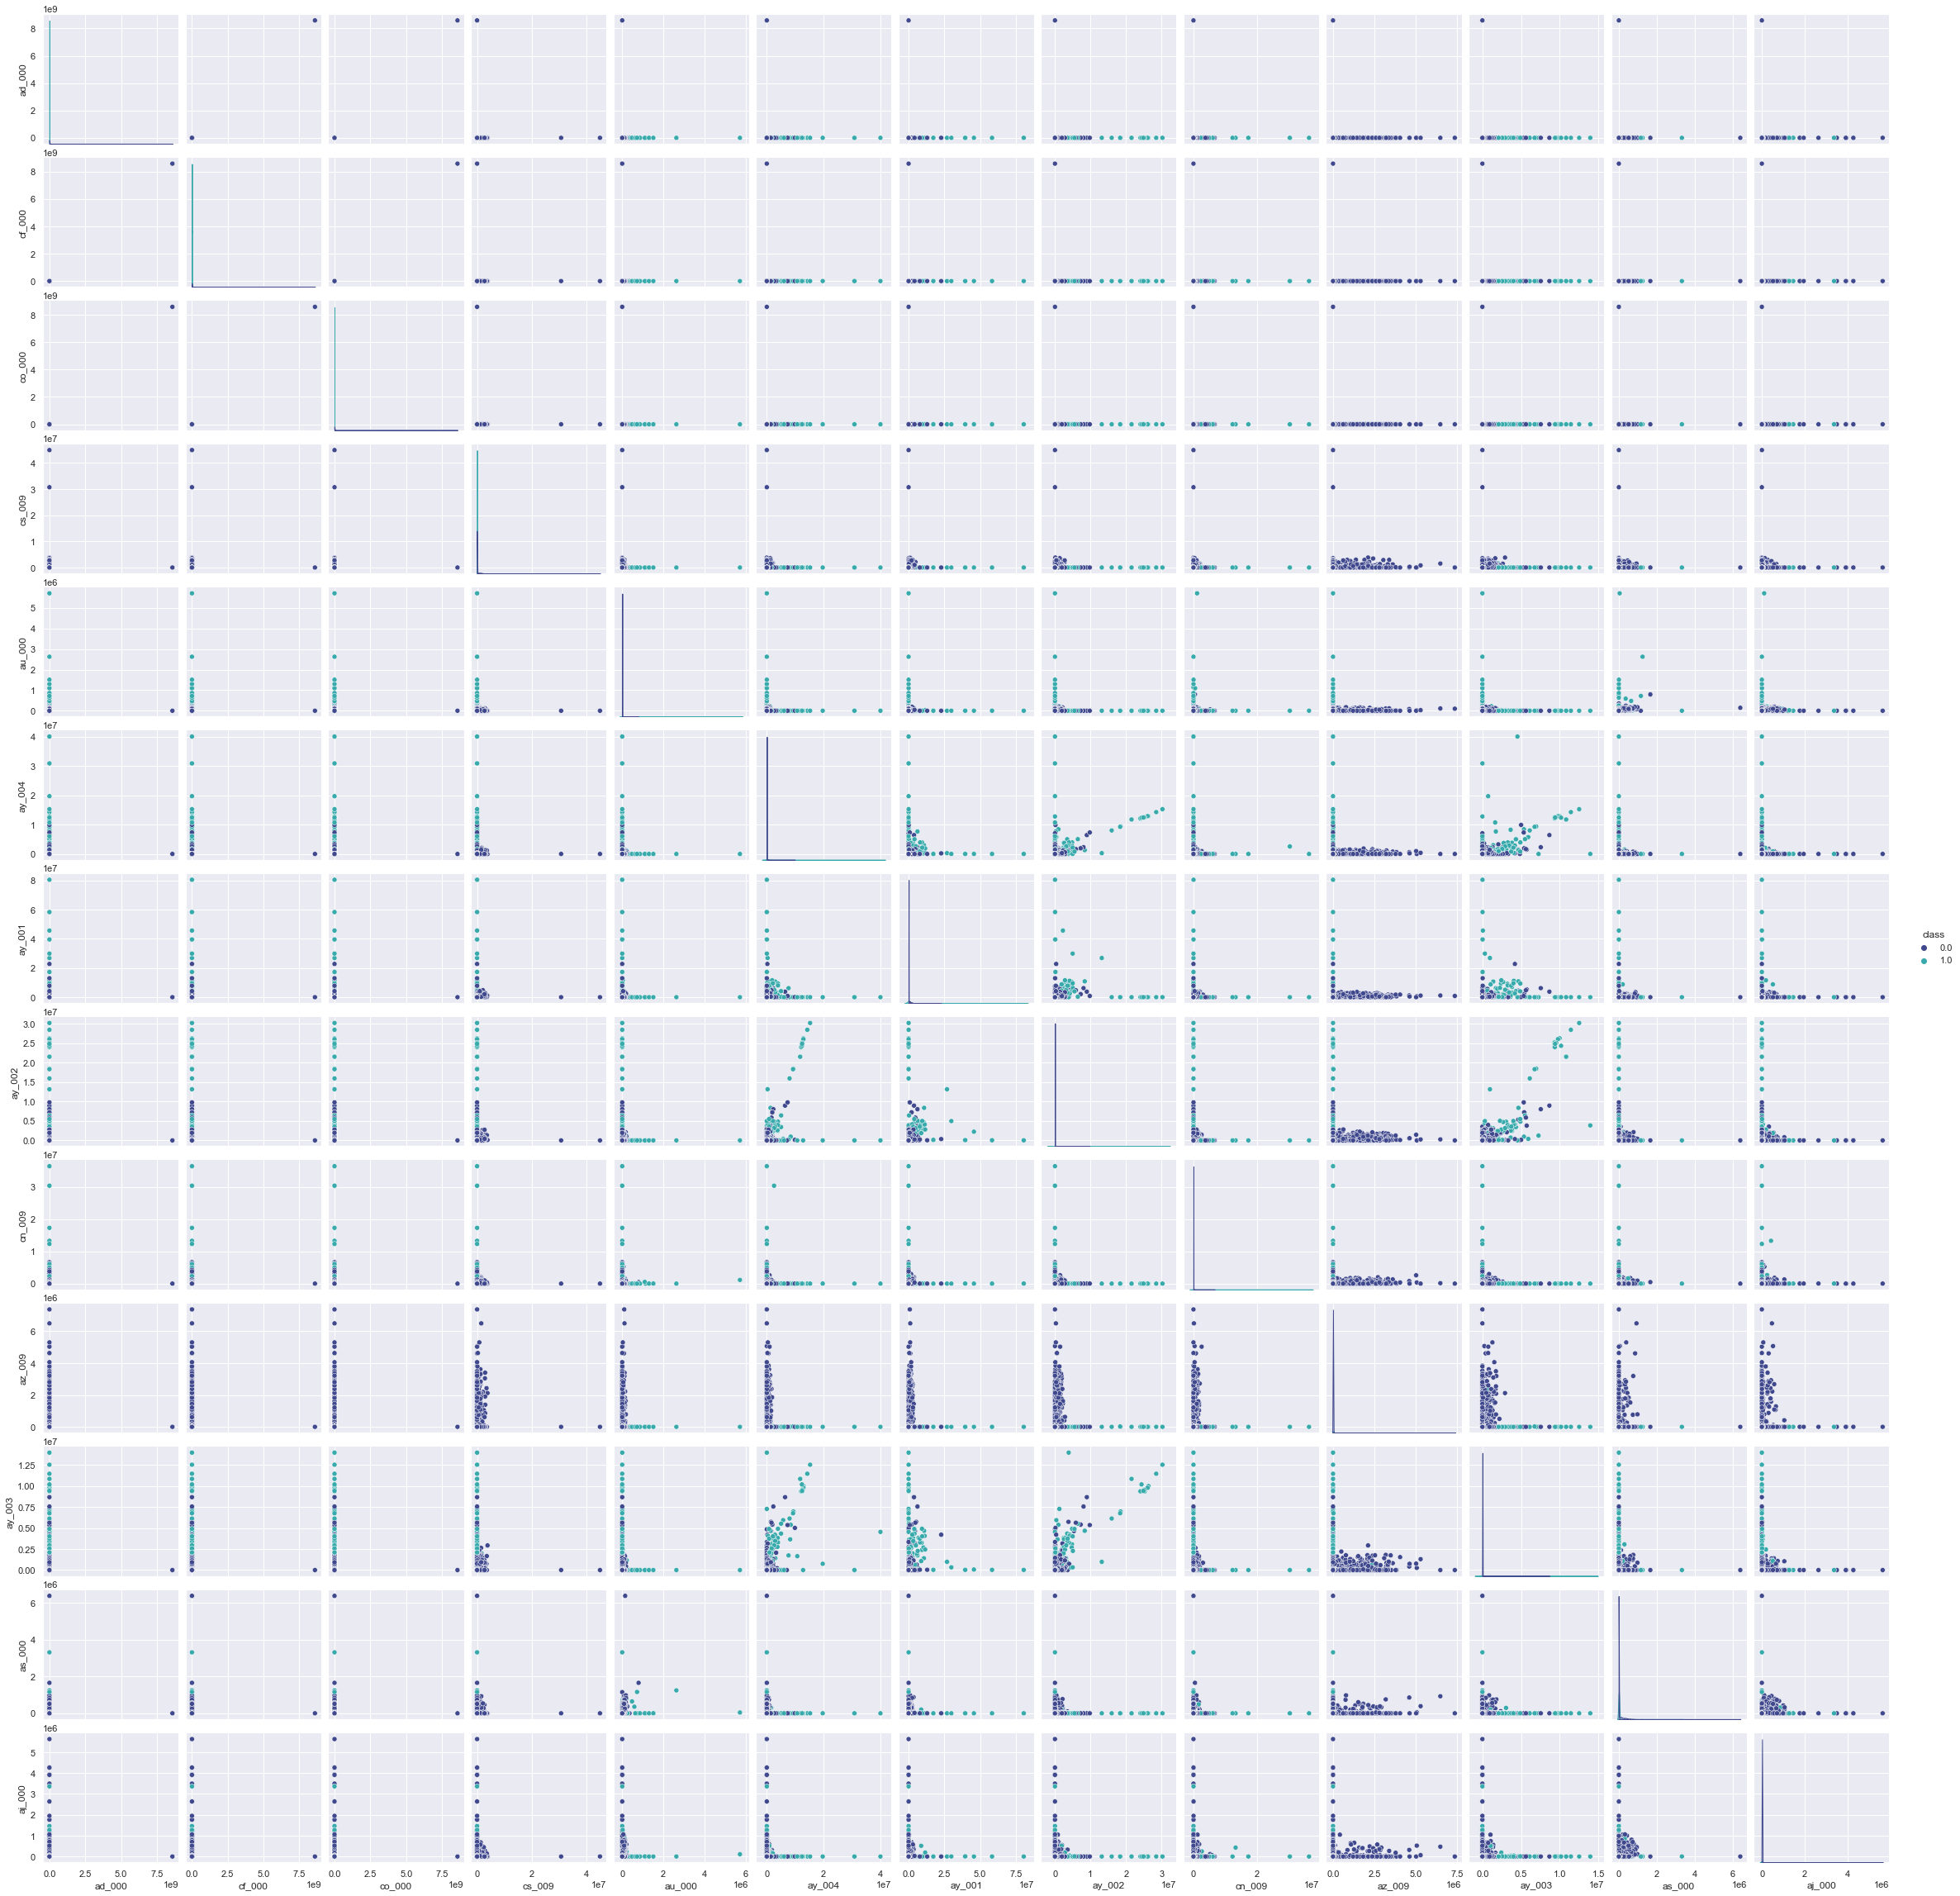

In [51]:
# Using the pairplot function of the seaborn library, plot graphs between all pairs of variables

sns.pairplot(df_aps_selected, hue='class', palette='mako')
sns.set(rc = {'figure.figsize':(20,20)})

It is difficult to judge the significance of these features by seeing the scatterplot, because the dots from different classes scatter at a similar value range for these features.

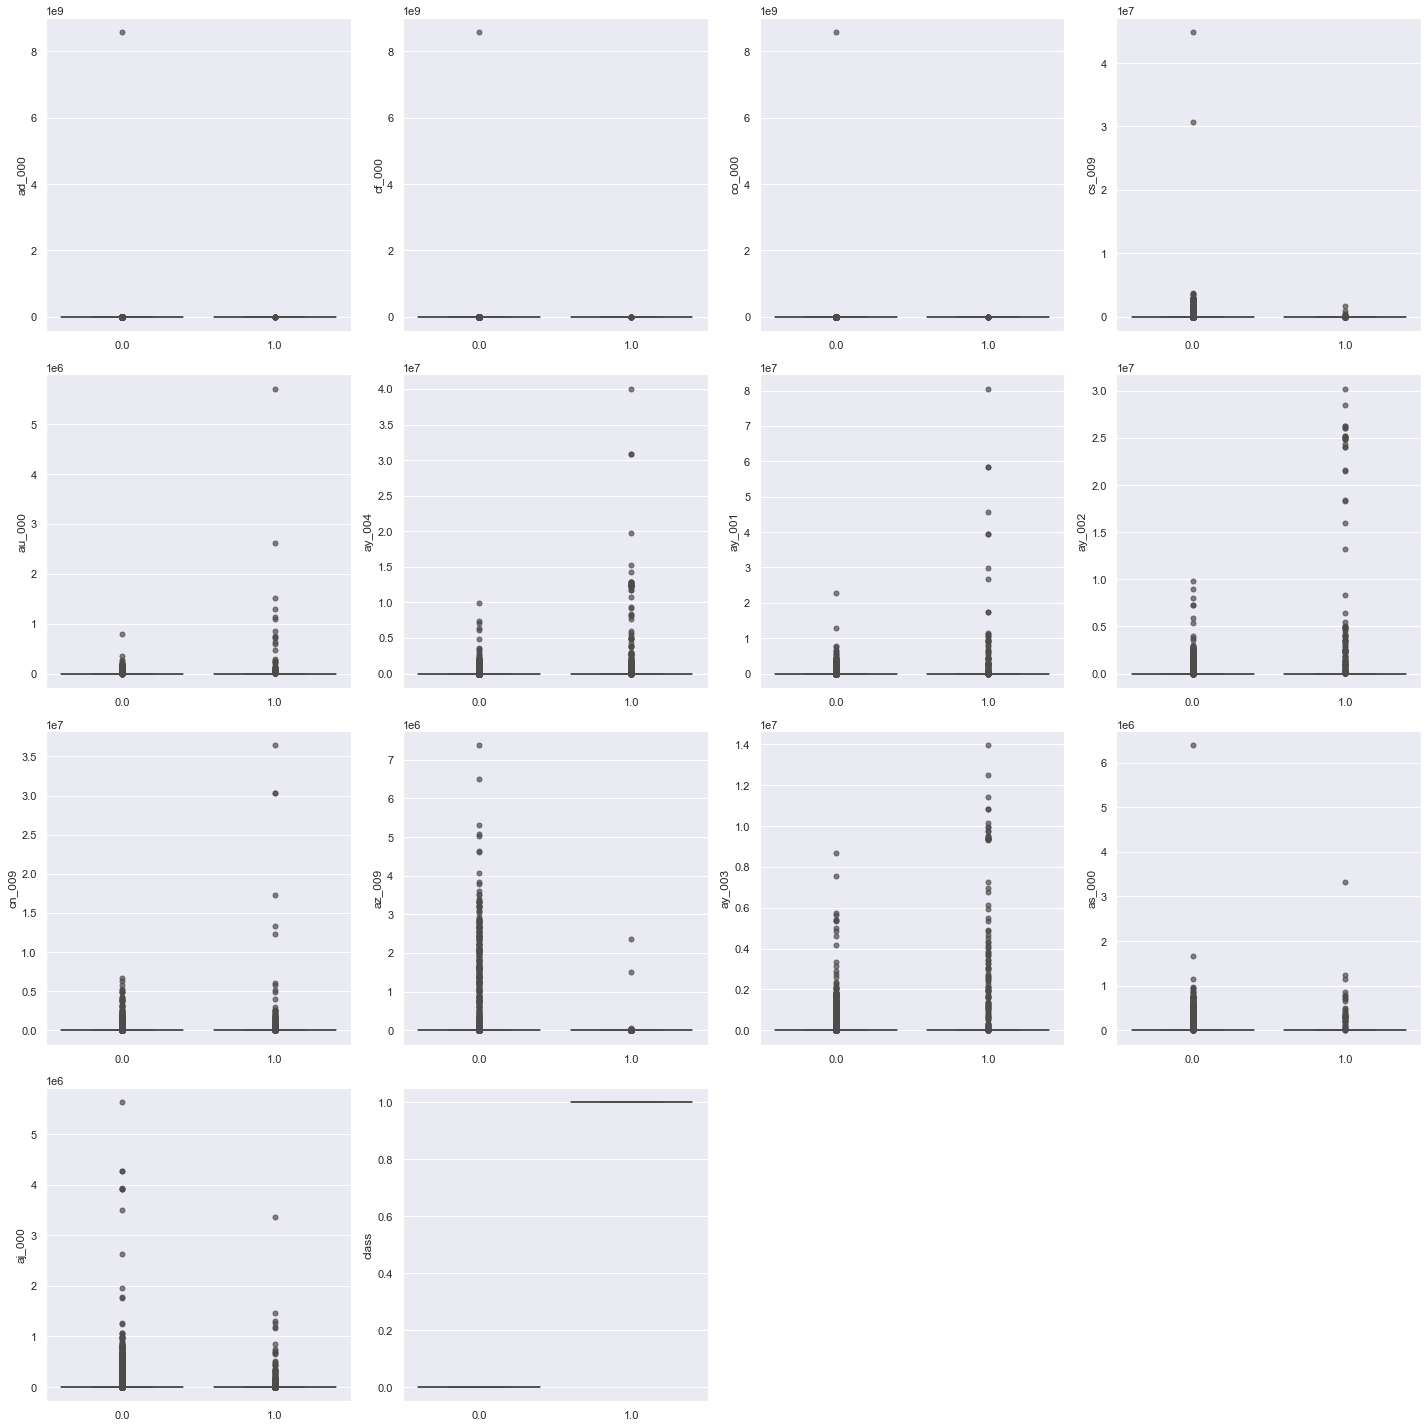

In [52]:
# Using the boxplot function of the seaborn library, plot a boxplot for all variables
# With the outliers

cols = df_aps_selected.columns.tolist()

plt.figure(figsize=(20,20))
flierprops = dict(marker='o', markersize=5, alpha=0.7) #set outliers'properties

for i, col in enumerate(cols, start=1):
    plt.subplot(4,4,i)
    sns.boxplot(x="class", y=col, data=df_aps_selected,flierprops=flierprops).xaxis.label.set_visible(False)
    plt.ylabel(cols[i-1])
    
plt.tight_layout()

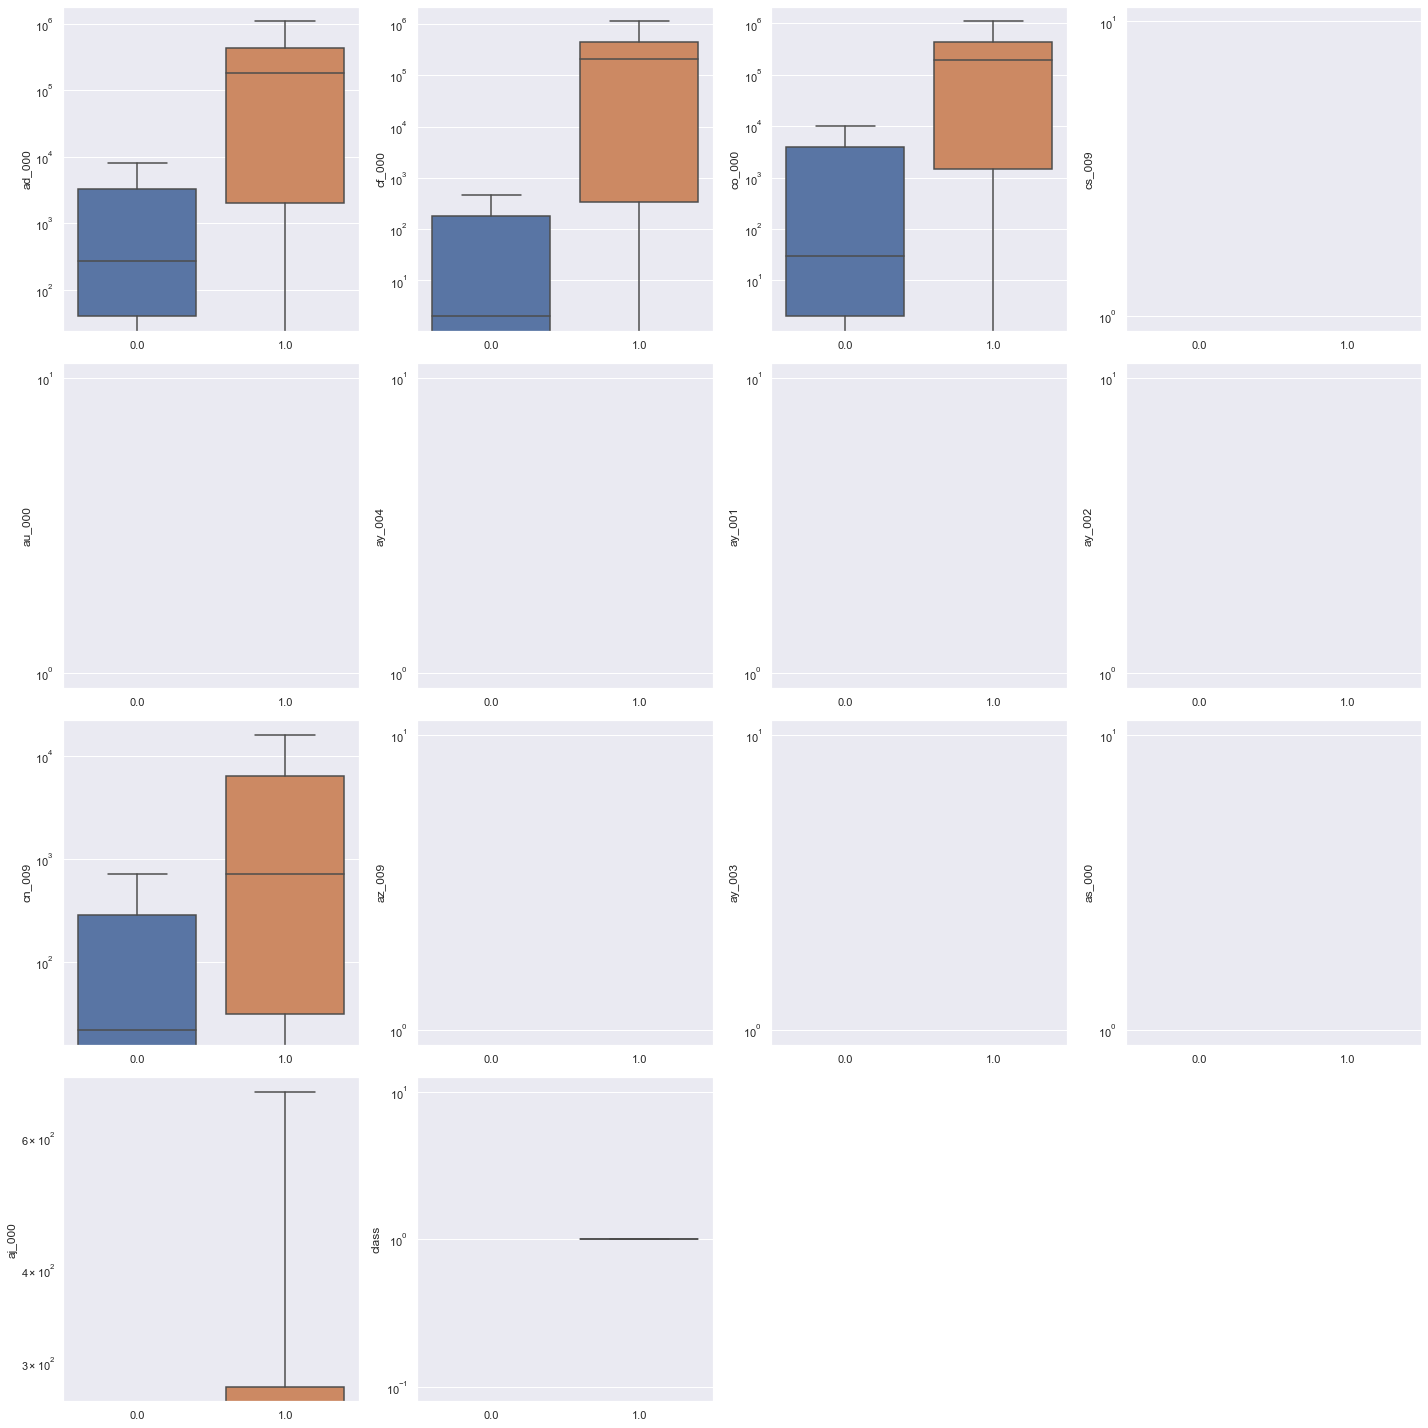

In [53]:
# Using the boxplot function of the seaborn library, plot a boxplot for all variables
# Without the outliers

cols = df_aps_selected.columns.tolist()

plt.figure(figsize=(20,20))
flierprops = dict(marker='o', markersize=5, alpha=0.7) #set outliers'properties

for i, col in enumerate(cols, start=1):
    plt.subplot(4,4,i)
    sns.boxplot(x="class", y=col, data=df_aps_selected,flierprops=flierprops,showfliers=False).xaxis.label.set_visible(False)
    plt.ylabel(cols[i-1])
    plt.yscale("log")
    
plt.tight_layout()

# v. Determine the number of positive and negative data. Is this data set imbalanced?

In [54]:
print("Number of positive data:")
len(y_aps[y_aps['class']==1])

Number of positive data:


1375

In [55]:
print("Number of negative data:")
len(y_aps[y_aps['class']==0])

Number of negative data:


74625

Yes, the data set is seriously imbalanced.

# (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

Train Data

Train Data Confusion Matrix:


<AxesSubplot:>

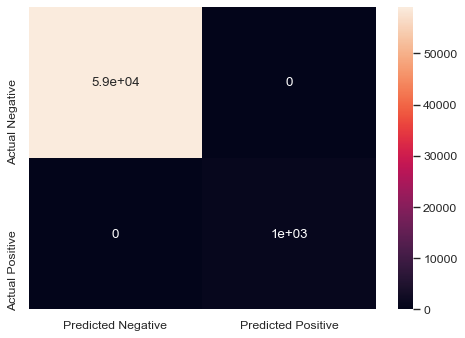

In [56]:
random_forest = RandomForestClassifier(oob_score=True,n_jobs=-1,random_state=100).fit(x_train,y_train)
y_train_pred = random_forest.predict(x_train)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Train Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [57]:
# Train Data Performance Measures

d = {'Accuracy': [accuracy_score(y_train, y_train_pred)] , 'Error' : [1-(accuracy_score(y_train, y_train_pred))]}
df_measures = pd.DataFrame(data=d,index=['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
Accuracy                              1.0
Error                                 0.0

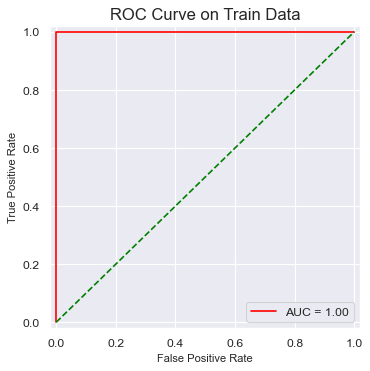

In [58]:
# ROC Curve for Train Data

from sklearn.metrics import roc_curve, auc

y_proba_train = random_forest.predict_proba(x_train)
y_proba_train_pos = y_proba_train[:,1]
fpr, tpr, threshold = roc_curve(y_train, y_proba_train_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Train Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [59]:
# AUC for Train Data

d = {'AUC': [roc_auc_score(y_train, y_proba_train_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
AUC                              1.0

In [60]:
# Misclassification for Train Data

mis_cl = (cm['Predicted Positive']['Actual Negative']+cm['Predicted Negative']['Actual Positive'])/ sum(cm.values[0]+cm.values[1])
print("Misclassification on Train Data:",mis_cl)

Misclassification on Train Data: 0.0


Test Data

Test Data Confusion Matrix:


<AxesSubplot:>

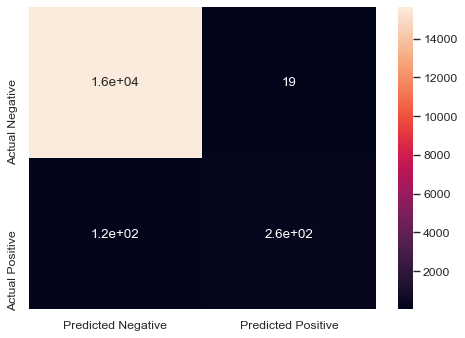

In [61]:
y_test_pred = random_forest.predict(x_test)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Test Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [62]:
# Test Data Performance Measures

d = {'Accuracy': [accuracy_score(y_test, y_test_pred)] , 'Error' : [1-(accuracy_score(y_test, y_test_pred))]}
df_measures = pd.DataFrame(data=d,index=['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
Accuracy                        0.991375
Error                           0.008625

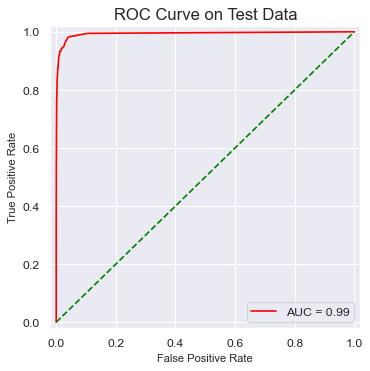

In [63]:
# ROC Curve for Test Data

from sklearn.metrics import roc_curve, auc

y_proba_test = random_forest.predict_proba(x_test)
y_proba_test_pos = y_proba_test[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba_test_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Test Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [64]:
# AUC for Test Data

d = {'AUC': [roc_auc_score(y_test, y_proba_test_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
AUC                        0.993682

In [65]:
# Misclassification for test data

mis_cl = (cm['Predicted Positive']['Actual Negative']+cm['Predicted Negative']['Actual Positive'])/ sum(cm.values[0]+cm.values[1])
print("Misclassification on Test Data:",mis_cl)

Misclassification on Test Data: 0.008625


In [66]:
print("Out of Bag Error Estimate:",random_forest.oob_score_)

Out of Bag Error Estimate: 0.9932833333333333


Test Error- 0.008625
Out of Bag Error Estimate: 0.9932833333333333

After building a random forest on this highly imbalanced data set, we can see that our model finds it easier to classify the data points to the negative class(majority class), which results in high accuracy(low test error) due to the large amount of correct classification of the majority class, but low TPR, which means a lower ability to correctly classify the positive class(minority class).

# (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

Train Data

Train Data Confusion Matrix:


<AxesSubplot:>

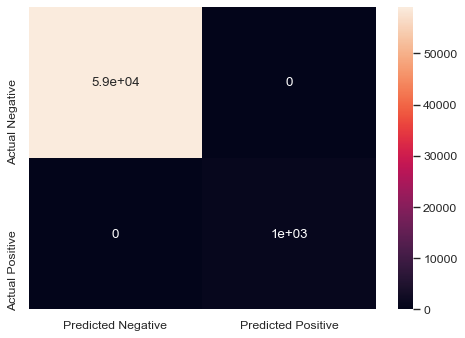

In [67]:
# Used a paramter class_weight='balanced' of the RandomForestClassifier to deal with the class imbalance

random_forest = RandomForestClassifier(class_weight='balanced',oob_score=True,n_jobs=-1,random_state=100).fit(x_train,y_train)
y_train_pred = random_forest.predict(x_train)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Train Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [68]:
# Train Data Performance Measures

d = {'Accuracy': [accuracy_score(y_train, y_train_pred)] , 'Error' : [1-(accuracy_score(y_train, y_train_pred))]}
df_measures = pd.DataFrame(data=d,index=['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
Accuracy                              1.0
Error                                 0.0

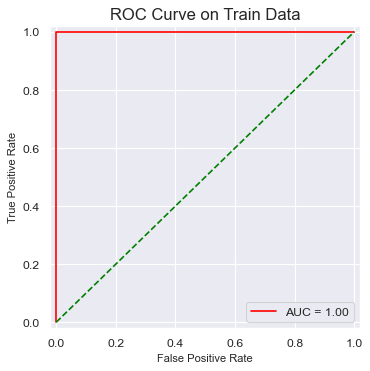

In [69]:
# ROC Curve for Train Data

from sklearn.metrics import roc_curve, auc

y_proba_train = random_forest.predict_proba(x_train)
y_proba_train_pos = y_proba_train[:,1]
fpr, tpr, threshold = roc_curve(y_train, y_proba_train_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Train Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [70]:
# AUC for Train Data

d = {'AUC': [roc_auc_score(y_train, y_proba_train_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
AUC                              1.0

In [71]:
# Misclassification for train data

mis_cl = (cm['Predicted Positive']['Actual Negative']+cm['Predicted Negative']['Actual Positive'])/ sum(cm.values[0]+cm.values[1])
print("Misclassification on Train Data:",mis_cl)

Misclassification on Train Data: 0.0


Test Data

Test Data Confusion Matrix:


<AxesSubplot:>

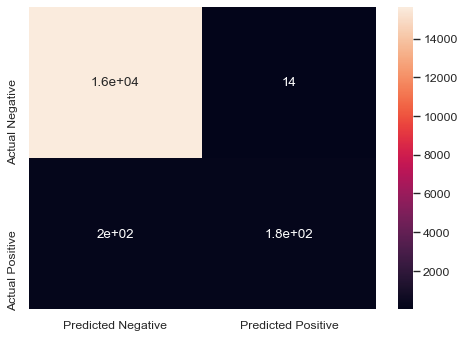

In [72]:
y_test_pred = random_forest.predict(x_test)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Test Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [73]:
# Test Data Performance Measures

d = {'Accuracy': [accuracy_score(y_test, y_test_pred)] , 'Error' : [1-(accuracy_score(y_test, y_test_pred))]}
df_measures = pd.DataFrame(data=d,index=['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
Accuracy                        0.986938
Error                           0.013062

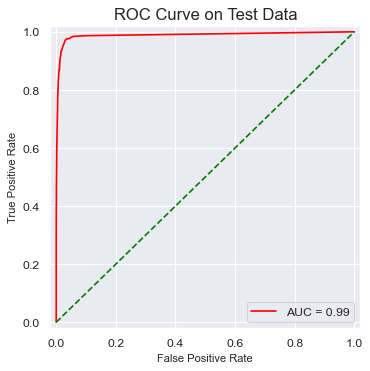

In [74]:
# ROC Curve for Test Data

from sklearn.metrics import roc_curve, auc

y_proba_test = random_forest.predict_proba(x_test)
y_proba_test_pos = y_proba_test[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba_test_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Test Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [75]:
# AUC for Test Data

d = {'AUC': [roc_auc_score(y_test, y_proba_test_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
AUC                        0.988645

In [76]:
# Misclassification for test data

mis_cl = (cm['Predicted Positive']['Actual Negative']+cm['Predicted Negative']['Actual Positive'])/ sum(cm.values[0]+cm.values[1])
print("Misclassification on Test Data:",mis_cl)

Misclassification on Test Data: 0.0130625


In [77]:
print("Out of Bag Error Estimate:",random_forest.oob_score_)

Out of Bag Error Estimate: 0.9911333333333333


Test Error- 0.013062
Out of Bag Error Estimate: 0.9911333333333333

After building a random forest post addressing class imbalance, we can see that our model even though results in a slightly lower accuracy, but still results in higher TPR, which means a higher ability to correctly classify the positive class(minority class).

# (e) Model Trees- In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classi cation trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has summ j  BjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. One can use scikit learn to call Weka7 to train Logistic Model Trees for classification. Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [78]:
# Combine x_train and y_train

df_aps_train = pd.concat([x_train,y_train],axis=1)
df_aps_train['class'] = np.where(df_aps_train['class']==1,'pos','neg')
df_aps_train

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0       76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1       33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2       41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3          12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4       60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...         ...         ...           ...            ...     ...     ...   
59995  153002.0  110.008832  6.640000e+02     186.000000     0.0     0.0   
59996    2286.0   71.143877  2.130707e+09     224.000000     0.0     0.0   
59997     112.0    0.000000  2.130706e+09      18.000000     0.0     0.0   
59998   80292.0   97.978511  2.130706e+09     494.000000     0.0     0.0   
59999   40222.0  137.370253  6.980000e+02     628.000000     0.0     0.0   

       ag_000  ag_001  ag_002  ag_003  ...    ee_003     ee_004     ee_005  \
0         0.0     0.0     0.0     0.0  ...  493384.0   721044.0   469792.0   
1         0.0     0.0     0.0     0.0  ...  178064.0   293306.0   245416.0   
2         0.0     0.0     0.0     0.0  ...  159812.0   423992.0   409564.0   
3         0.0     0.0     0.0   318.0  ...      46.0       58.0       44.0   
4         0.0     0.0     0.0     0.0  ...  229790.0   405298.0   347188.0   
...       ...     ...     ...     ...  ...       ...        ...        ...   
59995     0.0     0.0     0.0  2564.0  ...  566884.0  1290398.0  1218244.0   
59996     0.0     0.0     0.0     0.0  ...    6760.0    21126.0    68424.0   
59997     0.0     0.0     0.0     0.0  ...     386.0      452.0      144.0   
59998     0.0     0.0     0.0     0.0  ...  222654.0   347378.0   225724.0   
59999     0.0     0.0     0.0     0.0  ...  183200.0   344546.0   254068.0   

          ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  class  
0       339156.0  157956.0   73224.0       0.0     0.0     0.0    neg  
1       133654.0   81140.0   97576.0    1500.0     0.0     0.0    neg  
2       320746.0  158022.0   95128.0     514.0     0.0     0.0    neg  
3           10.0       0.0       0.0       0.0     4.0    32.0    neg  
4       286954.0  311560.0  433954.0    1218.0     0.0     0.0    neg  
...          ...       ...       ...       ...     ...     ...    ...  
59995  1019768.0  717762.0  898642.0   28588.0     0.0     0.0    neg  
59996      136.0       0.0       0.0       0.0     0.0     0.0    neg  
59997      146.0    2622.0       0.0       0.0     0.0     0.0    neg  
59998   194440.0  165070.0  802280.0  388422.0     0.0     0.0    neg  
59999   225148.0  158304.0  170384.0     158.0     0.0     0.0    neg  

[60000 rows x 171 columns]

In [79]:
# Split the train dataframe into x_train and y_train

x_train = df_aps_train.iloc[:,0:len(df_aps_train.columns)-1]
y_train = df_aps_train.iloc[:,-1].to_frame()

In [80]:
x_train

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0       76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1       33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2       41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3          12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4       60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...         ...         ...           ...            ...     ...     ...   
59995  153002.0  110.008832  6.640000e+02     186.000000     0.0     0.0   
59996    2286.0   71.143877  2.130707e+09     224.000000     0.0     0.0   
59997     112.0    0.000000  2.130706e+09      18.000000     0.0     0.0   
59998   80292.0   97.978511  2.130706e+09     494.000000     0.0     0.0   
59999   40222.0  137.370253  6.980000e+02     628.000000     0.0     0.0   

       ag_000  ag_001  ag_002  ag_003  ...     ee_002    ee_003     ee_004  \
0         0.0     0.0     0.0     0.0  ...  1240520.0  493384.0   721044.0   
1         0.0     0.0     0.0     0.0  ...   421400.0  178064.0   293306.0   
2         0.0     0.0     0.0     0.0  ...   277378.0  159812.0   423992.0   
3         0.0     0.0     0.0   318.0  ...      240.0      46.0       58.0   
4         0.0     0.0     0.0     0.0  ...   622012.0  229790.0   405298.0   
...       ...     ...     ...     ...  ...        ...       ...        ...   
59995     0.0     0.0     0.0  2564.0  ...   998500.0  566884.0  1290398.0   
59996     0.0     0.0     0.0     0.0  ...    10578.0    6760.0    21126.0   
59997     0.0     0.0     0.0     0.0  ...      792.0     386.0      452.0   
59998     0.0     0.0     0.0     0.0  ...   699352.0  222654.0   347378.0   
59999     0.0     0.0     0.0     0.0  ...   440066.0  183200.0   344546.0   

          ee_005     ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  
0       469792.0   339156.0  157956.0   73224.0       0.0     0.0     0.0  
1       245416.0   133654.0   81140.0   97576.0    1500.0     0.0     0.0  
2       409564.0   320746.0  158022.0   95128.0     514.0     0.0     0.0  
3           44.0       10.0       0.0       0.0       0.0     4.0    32.0  
4       347188.0   286954.0  311560.0  433954.0    1218.0     0.0     0.0  
...          ...        ...       ...       ...       ...     ...     ...  
59995  1218244.0  1019768.0  717762.0  898642.0   28588.0     0.0     0.0  
59996    68424.0      136.0       0.0       0.0       0.0     0.0     0.0  
59997      144.0      146.0    2622.0       0.0       0.0     0.0     0.0  
59998   225724.0   194440.0  165070.0  802280.0  388422.0     0.0     0.0  
59999   254068.0   225148.0  158304.0  170384.0     158.0     0.0     0.0  

[60000 rows x 170 columns]

In [81]:
y_train

class
0       neg
1       neg
2       neg
3       neg
4       neg
...     ...
59995   neg
59996   neg
59997   neg
59998   neg
59999   neg

[60000 rows x 1 columns]

In [82]:
# Export the data to a csv

df_aps_train.to_csv("../data/aps_train_data.csv", sep=',', index=False)
df_aps_train_data = convert.load_any_file(filename="../data/aps_train_data.csv")
df_aps_train_data.class_is_last()

WITH CV

In [83]:
# WITH CV

# Load logistic model tree(LMT) algorithm

log_tree = Classifier(classname="weka.classifiers.trees.LMT")
eval_train_obj = Evaluation(df_aps_train_data)
eval_train_obj.crossvalidate_model(classifier=log_tree,data=df_aps_train_data,num_folds=5,rnd=Random(1))

Time taken: 1730.3550651073456


In [84]:
print("Train Data Confusion Matrix(CV):")
print('\n')
print(eval_train_obj.matrix())

Train Data Confusion Matrix(CV):


=== Confusion Matrix ===

     a     b   <-- classified as
 58838   162 |     a = neg
   381   619 |     b = pos



In [85]:
# Train Data Performance Measures

d = {'Accuracy': [eval_train_obj.percent_correct] , 'Error' : [eval_train_obj.percent_incorrect]}
df_measures = pd.DataFrame(data=d,index=['Train Data Performance Measures(CV)'])
df_measures.T

Train Data Performance Measures(CV)
Accuracy                               99.095
Error                                   0.905

In [86]:
# Summary

print("Train Data Summary(CV):")
print(eval_train_obj.summary())

Train Data Summary(CV):

Correctly Classified Instances       59457               99.095  %
Incorrectly Classified Instances       543                0.905  %
Kappa statistic                          0.6906
Mean absolute error                      0.0129
Root mean squared error                  0.085 
Relative absolute error                 39.2795 %
Root relative squared error             66.4201 %
Total Number of Instances            60000     



<Figure size 560x400 with 0 Axes>

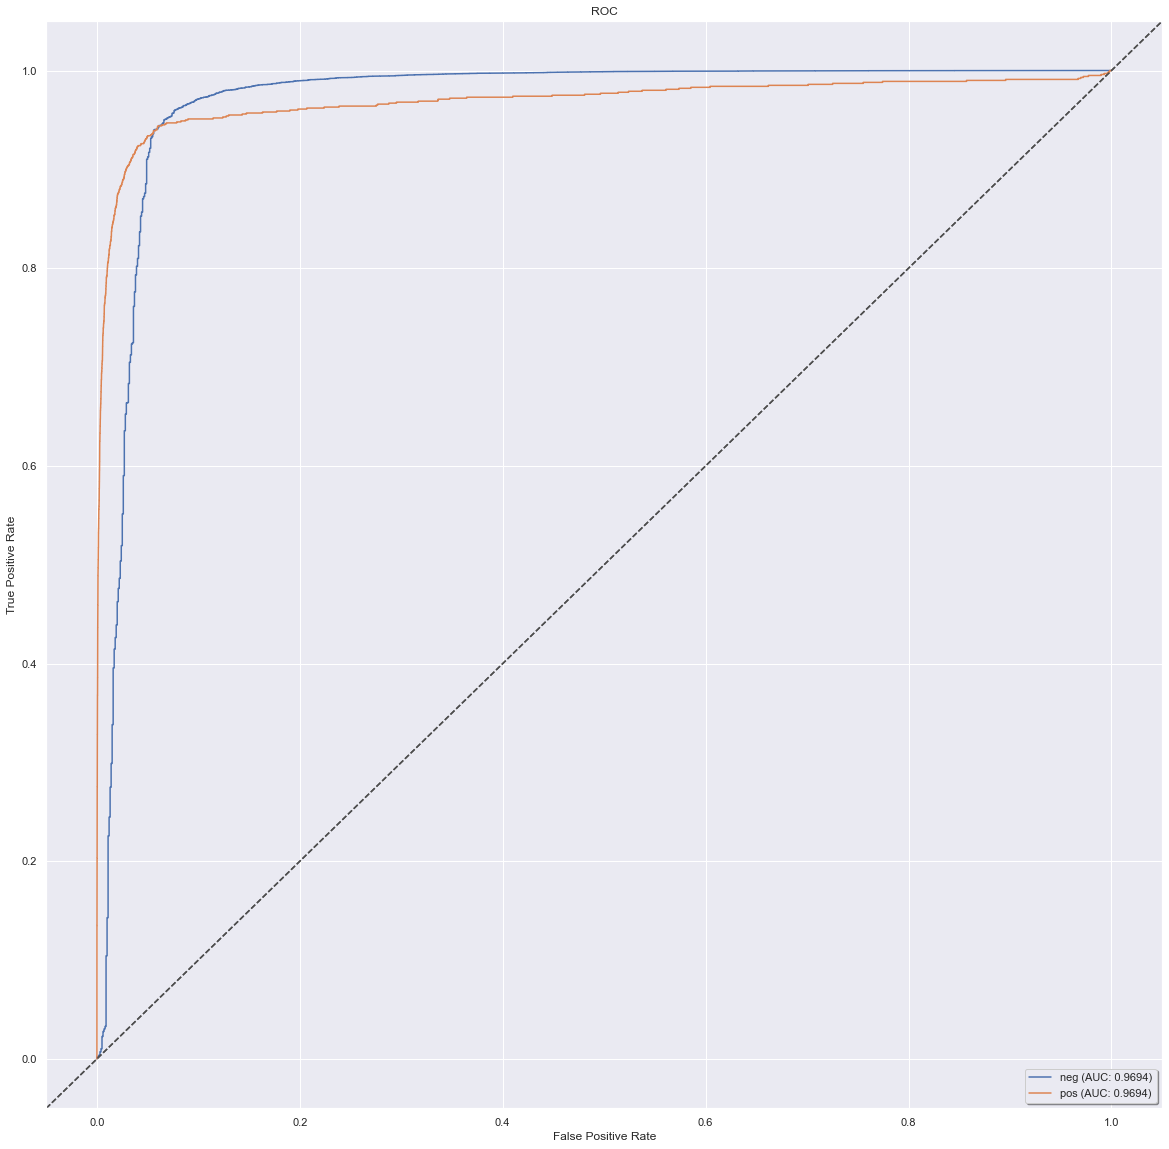

In [87]:
# ROC Curve for Train Data(CV)

plcls.plot_roc(eval_train_obj, class_index=[0, 1], wait=True)

In [88]:
# AUC
# Class details

print("Train Data Class Details(CV):")
print(eval_train_obj.class_details())

Train Data Class Details(CV):
=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.381    0.994      0.997    0.995      0.696    0.969     0.999     neg
                 0.619    0.003    0.793      0.619    0.695      0.696    0.969     0.759     pos
Weighted Avg.    0.991    0.375    0.990      0.991    0.990      0.696    0.969     0.995     



In [89]:
# AUC for Train Data CV

print("AUC for negative data: 0.969")
print("AUC for positive data: 0.969")

AUC for negative data: 0.969
AUC for positive data: 0.969


WITHOUT CV
ON ENTIRE TRAIN DATASET

In [90]:
# WITHOUT CV

# Build the classifier on the entire train dataset
log_tree.build_classifier(df_aps_train_data)

Time taken: 499.7020671367645


Train Data

Train Data Confusion Matrix:


<AxesSubplot:>

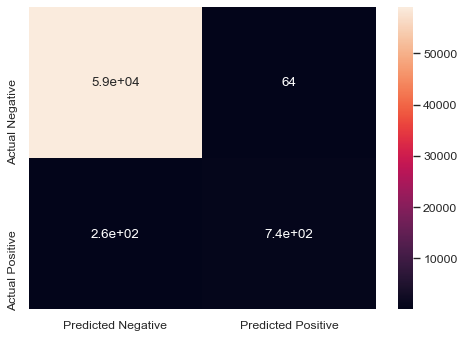

In [91]:
y_train['class'] = np.where(y_train['class']=='pos',1,0)

y_train_pred = np.zeros_like(y_train)

for i,ins in enumerate(df_aps_train_data):
    y_train_pred[i] = log_tree.classify_instance(ins)
    
y_train_pred = y_train_pred.astype(np.float)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Train Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [92]:
# Train Data Performance Measures

d = {'Accuracy': [accuracy_score(y_train, y_train_pred)] , 'Error' : [1-(accuracy_score(y_train, y_train_pred))]}
df_measures = pd.DataFrame(data=d,index=['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
Accuracy                           0.9946
Error                              0.0054

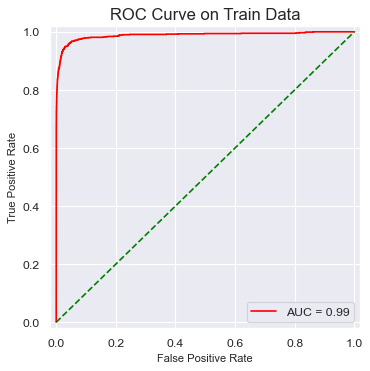

In [93]:
# ROC Curve for Train Data

from sklearn.metrics import roc_curve, auc

y_proba_train = np.zeros((60000,2))

for i,ins in enumerate(df_aps_train_data):
    y_proba_train[i] = log_tree.distribution_for_instance(ins)
y_proba_train_pos = y_proba_train[:,1]

fpr, tpr, threshold = roc_curve(y_train, y_proba_train_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Train Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [94]:
# AUC for Train Data

d = {'AUC': [roc_auc_score(y_train, y_proba_train_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
AUC                         0.988225

Test Data

In [95]:
# Combine x_test and y_test

df_aps_test = pd.concat([x_test,y_test],axis=1)
df_aps_test['class'] = np.where(df_aps_test['class']==1,'pos','neg')
df_aps_test

aa_000      ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0         60.0    0.000000  2.000000e+01    12.0     0.0     0.0     0.0   
1         82.0    0.000000  6.800000e+01    40.0     0.0     0.0     0.0   
2      66002.0    2.000000  2.120000e+02   112.0     0.0     0.0     0.0   
3      59816.0   32.933299  1.010000e+03   936.0     0.0     0.0     0.0   
4       1814.0  168.082015  1.560000e+02   140.0     0.0     0.0     0.0   
...        ...         ...           ...     ...     ...     ...     ...   
15995  81852.0  119.662509  2.130706e+09   892.0     0.0     0.0     0.0   
15996     18.0    0.000000  5.200000e+01    46.0     8.0    26.0     0.0   
15997  79636.0   64.489815  1.670000e+03  1518.0     0.0     0.0     0.0   
15998    110.0  113.971224  3.600000e+01    32.0     0.0     0.0     0.0   
15999      8.0    0.000000  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002    ag_003  ...    ee_003    ee_004    ee_005     ee_006  \
0         0.0     0.0    2682.0  ...     138.0     412.0     654.0       78.0   
1         0.0     0.0       0.0  ...     276.0    1620.0     116.0       86.0   
2         0.0     0.0  199486.0  ...  380368.0  440134.0  269556.0  1315022.0   
3         0.0     0.0       0.0  ...  243270.0  483302.0  485332.0   431376.0   
4         0.0     0.0       0.0  ...    4144.0   18466.0   49782.0     3176.0   
...       ...     ...       ...  ...       ...       ...       ...        ...   
15995     0.0     0.0       0.0  ...  273242.0  510354.0  373918.0   349840.0   
15996     0.0     0.0       0.0  ...      44.0      46.0      14.0        2.0   
15997     0.0     0.0       0.0  ...  449962.0  778826.0  581558.0   375498.0   
15998     0.0     0.0       0.0  ...     210.0     180.0     544.0     1004.0   
15999     0.0     0.0       0.0  ...      10.0      48.0      14.0       42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  class  
0          88.0       0.0      0.0     0.0     0.0    neg  
1         462.0       0.0      0.0     0.0     0.0    neg  
2      153680.0     516.0      0.0     0.0     0.0    neg  
3      210074.0  281662.0   3232.0     0.0     0.0    neg  
4         482.0      76.0      0.0     0.0     0.0    neg  
...         ...       ...      ...     ...     ...    ...  
15995  317840.0  960024.0  25566.0     0.0     0.0    neg  
15996       0.0       0.0      0.0     0.0     0.0    neg  
15997  222866.0  358934.0  19548.0     0.0     0.0    neg  
15998    1338.0      74.0      0.0     0.0     0.0    neg  
15999      46.0       0.0      0.0     0.0     0.0    neg  

[16000 rows x 171 columns]

In [96]:
# Split the test dataframe into x_test and y_test

x_test = df_aps_test.iloc[:,0:len(df_aps_test.columns)-1]
y_test = df_aps_test.iloc[:,-1].to_frame()

In [97]:
x_test

aa_000      ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0         60.0    0.000000  2.000000e+01    12.0     0.0     0.0     0.0   
1         82.0    0.000000  6.800000e+01    40.0     0.0     0.0     0.0   
2      66002.0    2.000000  2.120000e+02   112.0     0.0     0.0     0.0   
3      59816.0   32.933299  1.010000e+03   936.0     0.0     0.0     0.0   
4       1814.0  168.082015  1.560000e+02   140.0     0.0     0.0     0.0   
...        ...         ...           ...     ...     ...     ...     ...   
15995  81852.0  119.662509  2.130706e+09   892.0     0.0     0.0     0.0   
15996     18.0    0.000000  5.200000e+01    46.0     8.0    26.0     0.0   
15997  79636.0   64.489815  1.670000e+03  1518.0     0.0     0.0     0.0   
15998    110.0  113.971224  3.600000e+01    32.0     0.0     0.0     0.0   
15999      8.0    0.000000  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002    ag_003  ...    ee_002    ee_003    ee_004    ee_005  \
0         0.0     0.0    2682.0  ...    1098.0     138.0     412.0     654.0   
1         0.0     0.0       0.0  ...    1068.0     276.0    1620.0     116.0   
2         0.0     0.0  199486.0  ...  495076.0  380368.0  440134.0  269556.0   
3         0.0     0.0       0.0  ...  540820.0  243270.0  483302.0  485332.0   
4         0.0     0.0       0.0  ...    7646.0    4144.0   18466.0   49782.0   
...       ...     ...       ...  ...       ...       ...       ...       ...   
15995     0.0     0.0       0.0  ...  632658.0  273242.0  510354.0  373918.0   
15996     0.0     0.0       0.0  ...     266.0      44.0      46.0      14.0   
15997     0.0     0.0       0.0  ...  806832.0  449962.0  778826.0  581558.0   
15998     0.0     0.0       0.0  ...     588.0     210.0     180.0     544.0   
15999     0.0     0.0       0.0  ...      46.0      10.0      48.0      14.0   

          ee_006    ee_007    ee_008   ee_009  ef_000  eg_000  
0           78.0      88.0       0.0      0.0     0.0     0.0  
1           86.0     462.0       0.0      0.0     0.0     0.0  
2      1315022.0  153680.0     516.0      0.0     0.0     0.0  
3       431376.0  210074.0  281662.0   3232.0     0.0     0.0  
4         3176.0     482.0      76.0      0.0     0.0     0.0  
...          ...       ...       ...      ...     ...     ...  
15995   349840.0  317840.0  960024.0  25566.0     0.0     0.0  
15996        2.0       0.0       0.0      0.0     0.0     0.0  
15997   375498.0  222866.0  358934.0  19548.0     0.0     0.0  
15998     1004.0    1338.0      74.0      0.0     0.0     0.0  
15999       42.0      46.0       0.0      0.0     0.0     0.0  

[16000 rows x 170 columns]

In [98]:
y_test

class
0       neg
1       neg
2       neg
3       neg
4       neg
...     ...
15995   neg
15996   neg
15997   neg
15998   neg
15999   neg

[16000 rows x 1 columns]

In [99]:
# Export the data to a csv

df_aps_test.to_csv("../data/aps_test_data.csv", sep=',', index=False)
df_aps_test_data = convert.load_any_file(filename="../data/aps_test_data.csv")
df_aps_test_data.class_is_last()

Test Data Confusion Matrix:


<AxesSubplot:>

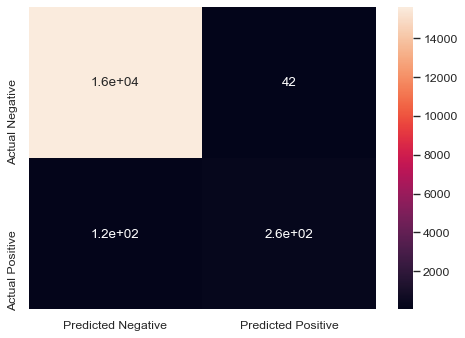

In [100]:
y_test['class'] = np.where(y_test['class']=='pos',1,0)

y_test_pred = np.zeros_like(y_test)

for i,ins in enumerate(df_aps_test_data):
    y_test_pred[i] = log_tree.classify_instance(ins)
    
y_test_pred = y_test_pred.astype(np.float)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Test Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [101]:
# Test Data Performance Measures

d = {'Accuracy': [accuracy_score(y_test, y_test_pred)] , 'Error' : [1-(accuracy_score(y_test, y_test_pred))]}
df_measures = pd.DataFrame(data=d,index=['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
Accuracy                        0.990187
Error                           0.009813

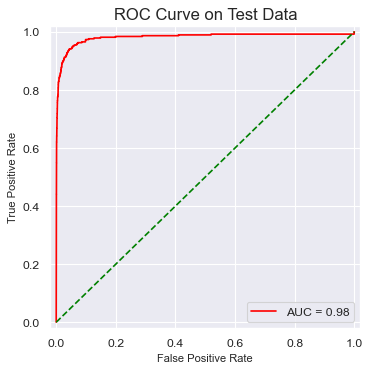

In [102]:
# ROC Curve for Test Data

from sklearn.metrics import roc_curve, auc

y_proba_test = np.zeros((16000,2))

for i,ins in enumerate(df_aps_test_data):
    y_proba_test[i] = log_tree.distribution_for_instance(ins)
y_proba_test_pos = y_proba_test[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_proba_test_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Test Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [103]:
# AUC for Test Data

d = {'AUC': [roc_auc_score(y_test, y_proba_test_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
AUC                        0.981281

The 5-fold cross-validation error(0.905) is higher than the test error(0.009813), however, it predicts the train data better than the test data(train error- 0.0054).

# (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

In [104]:
jvm.stop()
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/weka.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [105]:
# Combine x_train and y_train

df_aps_train = pd.concat([x_train,y_train],axis=1)
df_aps_train['class'] = np.where(df_aps_train['class']==1,'pos','neg')
df_aps_train

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0       76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1       33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2       41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3          12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4       60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...         ...         ...           ...            ...     ...     ...   
59995  153002.0  110.008832  6.640000e+02     186.000000     0.0     0.0   
59996    2286.0   71.143877  2.130707e+09     224.000000     0.0     0.0   
59997     112.0    0.000000  2.130706e+09      18.000000     0.0     0.0   
59998   80292.0   97.978511  2.130706e+09     494.000000     0.0     0.0   
59999   40222.0  137.370253  6.980000e+02     628.000000     0.0     0.0   

       ag_000  ag_001  ag_002  ag_003  ...    ee_003     ee_004     ee_005  \
0         0.0     0.0     0.0     0.0  ...  493384.0   721044.0   469792.0   
1         0.0     0.0     0.0     0.0  ...  178064.0   293306.0   245416.0   
2         0.0     0.0     0.0     0.0  ...  159812.0   423992.0   409564.0   
3         0.0     0.0     0.0   318.0  ...      46.0       58.0       44.0   
4         0.0     0.0     0.0     0.0  ...  229790.0   405298.0   347188.0   
...       ...     ...     ...     ...  ...       ...        ...        ...   
59995     0.0     0.0     0.0  2564.0  ...  566884.0  1290398.0  1218244.0   
59996     0.0     0.0     0.0     0.0  ...    6760.0    21126.0    68424.0   
59997     0.0     0.0     0.0     0.0  ...     386.0      452.0      144.0   
59998     0.0     0.0     0.0     0.0  ...  222654.0   347378.0   225724.0   
59999     0.0     0.0     0.0     0.0  ...  183200.0   344546.0   254068.0   

          ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  class  
0       339156.0  157956.0   73224.0       0.0     0.0     0.0    neg  
1       133654.0   81140.0   97576.0    1500.0     0.0     0.0    neg  
2       320746.0  158022.0   95128.0     514.0     0.0     0.0    neg  
3           10.0       0.0       0.0       0.0     4.0    32.0    neg  
4       286954.0  311560.0  433954.0    1218.0     0.0     0.0    neg  
...          ...       ...       ...       ...     ...     ...    ...  
59995  1019768.0  717762.0  898642.0   28588.0     0.0     0.0    neg  
59996      136.0       0.0       0.0       0.0     0.0     0.0    neg  
59997      146.0    2622.0       0.0       0.0     0.0     0.0    neg  
59998   194440.0  165070.0  802280.0  388422.0     0.0     0.0    neg  
59999   225148.0  158304.0  170384.0     158.0     0.0     0.0    neg  

[60000 rows x 171 columns]

In [106]:
# Split the train dataframe into x_train and y_train

x_train = df_aps_train.iloc[:,0:len(df_aps_train.columns)-1]
y_train = df_aps_train.iloc[:,-1].to_frame()

In [107]:
x_train

aa_000      ab_000        ac_000         ad_000  ae_000  af_000  \
0       76698.0   55.745402  2.130706e+09     280.000000     0.0     0.0   
1       33058.0  135.609828  0.000000e+00  739992.775141     0.0     0.0   
2       41040.0   50.240938  2.280000e+02     100.000000     0.0     0.0   
3          12.0    0.000000  7.000000e+01      66.000000     0.0    10.0   
4       60874.0  130.152802  1.368000e+03     458.000000     0.0     0.0   
...         ...         ...           ...            ...     ...     ...   
59995  153002.0  110.008832  6.640000e+02     186.000000     0.0     0.0   
59996    2286.0   71.143877  2.130707e+09     224.000000     0.0     0.0   
59997     112.0    0.000000  2.130706e+09      18.000000     0.0     0.0   
59998   80292.0   97.978511  2.130706e+09     494.000000     0.0     0.0   
59999   40222.0  137.370253  6.980000e+02     628.000000     0.0     0.0   

       ag_000  ag_001  ag_002  ag_003  ...     ee_002    ee_003     ee_004  \
0         0.0     0.0     0.0     0.0  ...  1240520.0  493384.0   721044.0   
1         0.0     0.0     0.0     0.0  ...   421400.0  178064.0   293306.0   
2         0.0     0.0     0.0     0.0  ...   277378.0  159812.0   423992.0   
3         0.0     0.0     0.0   318.0  ...      240.0      46.0       58.0   
4         0.0     0.0     0.0     0.0  ...   622012.0  229790.0   405298.0   
...       ...     ...     ...     ...  ...        ...       ...        ...   
59995     0.0     0.0     0.0  2564.0  ...   998500.0  566884.0  1290398.0   
59996     0.0     0.0     0.0     0.0  ...    10578.0    6760.0    21126.0   
59997     0.0     0.0     0.0     0.0  ...      792.0     386.0      452.0   
59998     0.0     0.0     0.0     0.0  ...   699352.0  222654.0   347378.0   
59999     0.0     0.0     0.0     0.0  ...   440066.0  183200.0   344546.0   

          ee_005     ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  
0       469792.0   339156.0  157956.0   73224.0       0.0     0.0     0.0  
1       245416.0   133654.0   81140.0   97576.0    1500.0     0.0     0.0  
2       409564.0   320746.0  158022.0   95128.0     514.0     0.0     0.0  
3           44.0       10.0       0.0       0.0       0.0     4.0    32.0  
4       347188.0   286954.0  311560.0  433954.0    1218.0     0.0     0.0  
...          ...        ...       ...       ...       ...     ...     ...  
59995  1218244.0  1019768.0  717762.0  898642.0   28588.0     0.0     0.0  
59996    68424.0      136.0       0.0       0.0       0.0     0.0     0.0  
59997      144.0      146.0    2622.0       0.0       0.0     0.0     0.0  
59998   225724.0   194440.0  165070.0  802280.0  388422.0     0.0     0.0  
59999   254068.0   225148.0  158304.0  170384.0     158.0     0.0     0.0  

[60000 rows x 170 columns]

In [108]:
y_train

class
0       neg
1       neg
2       neg
3       neg
4       neg
...     ...
59995   neg
59996   neg
59997   neg
59998   neg
59999   neg

[60000 rows x 1 columns]

In [109]:
# Export the data to a csv

df_aps_train.to_csv("../data/aps_smote_train_data.csv", sep=',', index=False)
df_aps_train_data = convert.load_any_file(filename="../data/aps_smote_train_data.csv")
df_aps_train_data.class_is_last()

WITH CV

In [110]:
# WITH CV

SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-S", "0"])

# Load logistic model tree(LMT) algorithm

log_tree = Classifier(classname="weka.classifiers.trees.LMT")

# Use SMOTE as a filter 

fil_clf = FilteredClassifier()
fil_clf.filter = SMOTE
fil_clf.classifier = log_tree

eval_train_obj = Evaluation(df_aps_train_data)
eval_train_obj.crossvalidate_model(classifier=fil_clf,data=df_aps_train_data,num_folds=5,rnd=Random(1))

Time taken: 2078.017357826233


In [111]:
print("Train Data Confusion Matrix(Smote CV):")
print('\n')
print(eval_train_obj.matrix())

Train Data Confusion Matrix(Smote CV):


=== Confusion Matrix ===

     a     b   <-- classified as
 58746   254 |     a = neg
   286   714 |     b = pos



In [112]:
# Train Data Performance Measures

d = {'Accuracy': [eval_train_obj.percent_correct] , 'Error' : [eval_train_obj.percent_incorrect]}
df_measures = pd.DataFrame(data=d,index=['Train Data Performance Measures(Smote CV)'])
df_measures.T

Train Data Performance Measures(Smote CV)
Accuracy                                       99.1
Error                                           0.9

In [113]:
#Summary

print("Train Data Summary(Smote CV):")
print(eval_train_obj.summary())

Train Data Summary(Smote CV):

Correctly Classified Instances       59460               99.1    %
Incorrectly Classified Instances       540                0.9    %
Kappa statistic                          0.721 
Mean absolute error                      0.0118
Root mean squared error                  0.0883
Relative absolute error                 36.0237 %
Root relative squared error             68.9814 %
Total Number of Instances            60000     



<Figure size 560x400 with 0 Axes>

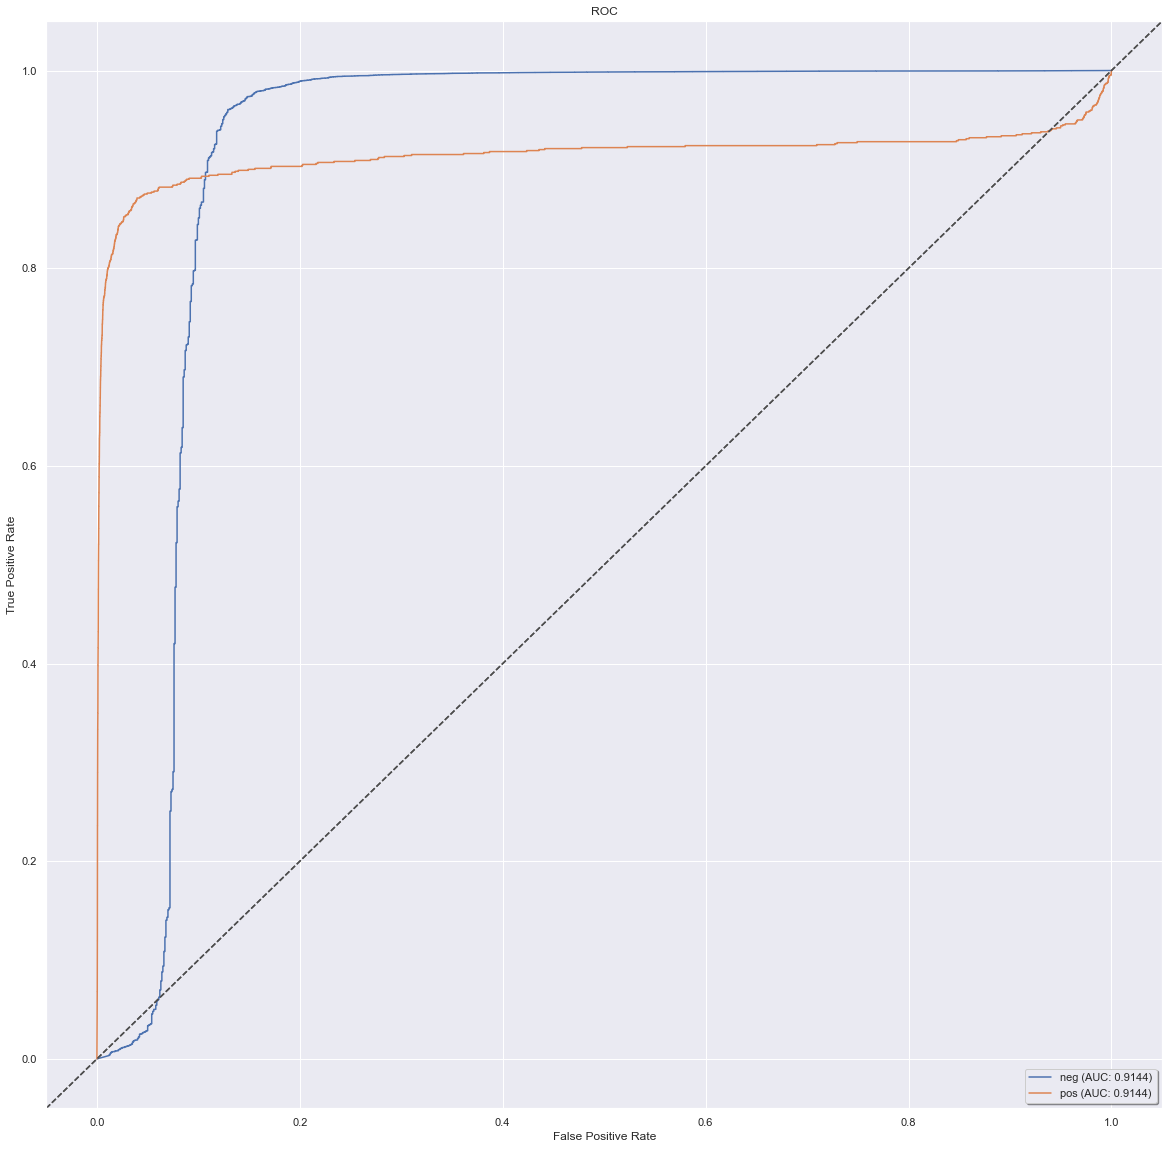

In [114]:
# ROC Curve for Train Data(Smote CV)

plcls.plot_roc(eval_train_obj, class_index=[0, 1], wait=True)

In [115]:
# AUC
# Class details

print("Train Data Class Details(Smote CV):")
print(eval_train_obj.class_details())

Train Data Class Details(Smote CV):
=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.996    0.286    0.995      0.996    0.995      0.721    0.914     0.995     neg
                 0.714    0.004    0.738      0.714    0.726      0.721    0.914     0.690     pos
Weighted Avg.    0.991    0.281    0.991      0.991    0.991      0.721    0.914     0.990     



In [116]:
# AUC for Train Data Smote CV

print("AUC for negative data: 0.914 ")
print("AUC for positive data: 0.914 ")

AUC for negative data: 0.914 
AUC for positive data: 0.914 


WITHOUT CV 
ON ENTIRE TRAIN DATASET

In [117]:
# WITHOUT CV

# Build the classifier on the entire train dataset

fil_clf.build_classifier(df_aps_train_data)

Time taken: 737.4970638751984


Train Data

Train Data Confusion Matrix:


<AxesSubplot:>

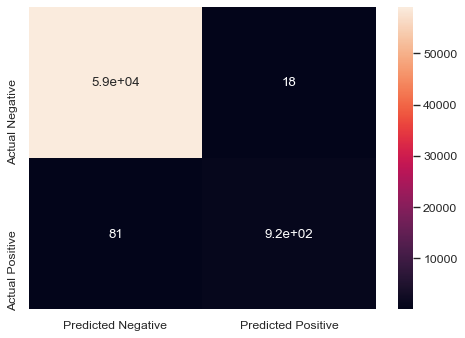

In [118]:
y_train['class'] = np.where(y_train['class']=='pos',1,0)

y_train_pred = np.zeros_like(y_train)

for i,ins in enumerate(df_aps_train_data):
    y_train_pred[i] = fil_clf.classify_instance(ins)
    
y_train_pred = y_train_pred.astype(np.float)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Train Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [119]:
# Train Data Performance Measures

d = {'Accuracy': [accuracy_score(y_train, y_train_pred)] , 'Error' : [1-(accuracy_score(y_train, y_train_pred))]}
df_measures = pd.DataFrame(data=d,index=['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
Accuracy                          0.99835
Error                             0.00165

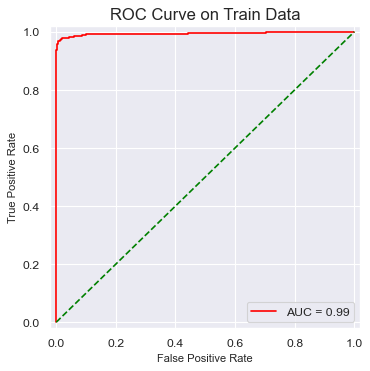

In [120]:
# ROC Curve for Train Data

from sklearn.metrics import roc_curve, auc

y_proba_train = np.zeros((60000,2))

for i,ins in enumerate(df_aps_train_data):
    y_proba_train[i] = fil_clf.distribution_for_instance(ins)
y_proba_train_pos = y_proba_train[:,1]

fpr, tpr, threshold = roc_curve(y_train, y_proba_train_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Train Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [121]:
# AUC for Train Data

d = {'AUC': [roc_auc_score(y_train, y_proba_train_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Train Data Performance Measures'])
df_measures.T

Train Data Performance Measures
AUC                         0.994376

Test Data

In [122]:
# Combine x_test and y_test

df_aps_test = pd.concat([x_test,y_test],axis=1)
df_aps_test['class'] = np.where(df_aps_test['class']==1,'pos','neg')
df_aps_test

aa_000      ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0         60.0    0.000000  2.000000e+01    12.0     0.0     0.0     0.0   
1         82.0    0.000000  6.800000e+01    40.0     0.0     0.0     0.0   
2      66002.0    2.000000  2.120000e+02   112.0     0.0     0.0     0.0   
3      59816.0   32.933299  1.010000e+03   936.0     0.0     0.0     0.0   
4       1814.0  168.082015  1.560000e+02   140.0     0.0     0.0     0.0   
...        ...         ...           ...     ...     ...     ...     ...   
15995  81852.0  119.662509  2.130706e+09   892.0     0.0     0.0     0.0   
15996     18.0    0.000000  5.200000e+01    46.0     8.0    26.0     0.0   
15997  79636.0   64.489815  1.670000e+03  1518.0     0.0     0.0     0.0   
15998    110.0  113.971224  3.600000e+01    32.0     0.0     0.0     0.0   
15999      8.0    0.000000  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002    ag_003  ...    ee_003    ee_004    ee_005     ee_006  \
0         0.0     0.0    2682.0  ...     138.0     412.0     654.0       78.0   
1         0.0     0.0       0.0  ...     276.0    1620.0     116.0       86.0   
2         0.0     0.0  199486.0  ...  380368.0  440134.0  269556.0  1315022.0   
3         0.0     0.0       0.0  ...  243270.0  483302.0  485332.0   431376.0   
4         0.0     0.0       0.0  ...    4144.0   18466.0   49782.0     3176.0   
...       ...     ...       ...  ...       ...       ...       ...        ...   
15995     0.0     0.0       0.0  ...  273242.0  510354.0  373918.0   349840.0   
15996     0.0     0.0       0.0  ...      44.0      46.0      14.0        2.0   
15997     0.0     0.0       0.0  ...  449962.0  778826.0  581558.0   375498.0   
15998     0.0     0.0       0.0  ...     210.0     180.0     544.0     1004.0   
15999     0.0     0.0       0.0  ...      10.0      48.0      14.0       42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  class  
0          88.0       0.0      0.0     0.0     0.0    neg  
1         462.0       0.0      0.0     0.0     0.0    neg  
2      153680.0     516.0      0.0     0.0     0.0    neg  
3      210074.0  281662.0   3232.0     0.0     0.0    neg  
4         482.0      76.0      0.0     0.0     0.0    neg  
...         ...       ...      ...     ...     ...    ...  
15995  317840.0  960024.0  25566.0     0.0     0.0    neg  
15996       0.0       0.0      0.0     0.0     0.0    neg  
15997  222866.0  358934.0  19548.0     0.0     0.0    neg  
15998    1338.0      74.0      0.0     0.0     0.0    neg  
15999      46.0       0.0      0.0     0.0     0.0    neg  

[16000 rows x 171 columns]

In [123]:
# Split the test dataframe into x_test and y_test

x_test = df_aps_test.iloc[:,0:len(df_aps_test.columns)-1]
y_test = df_aps_test.iloc[:,-1].to_frame()

In [124]:
x_test

aa_000      ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0         60.0    0.000000  2.000000e+01    12.0     0.0     0.0     0.0   
1         82.0    0.000000  6.800000e+01    40.0     0.0     0.0     0.0   
2      66002.0    2.000000  2.120000e+02   112.0     0.0     0.0     0.0   
3      59816.0   32.933299  1.010000e+03   936.0     0.0     0.0     0.0   
4       1814.0  168.082015  1.560000e+02   140.0     0.0     0.0     0.0   
...        ...         ...           ...     ...     ...     ...     ...   
15995  81852.0  119.662509  2.130706e+09   892.0     0.0     0.0     0.0   
15996     18.0    0.000000  5.200000e+01    46.0     8.0    26.0     0.0   
15997  79636.0   64.489815  1.670000e+03  1518.0     0.0     0.0     0.0   
15998    110.0  113.971224  3.600000e+01    32.0     0.0     0.0     0.0   
15999      8.0    0.000000  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002    ag_003  ...    ee_002    ee_003    ee_004    ee_005  \
0         0.0     0.0    2682.0  ...    1098.0     138.0     412.0     654.0   
1         0.0     0.0       0.0  ...    1068.0     276.0    1620.0     116.0   
2         0.0     0.0  199486.0  ...  495076.0  380368.0  440134.0  269556.0   
3         0.0     0.0       0.0  ...  540820.0  243270.0  483302.0  485332.0   
4         0.0     0.0       0.0  ...    7646.0    4144.0   18466.0   49782.0   
...       ...     ...       ...  ...       ...       ...       ...       ...   
15995     0.0     0.0       0.0  ...  632658.0  273242.0  510354.0  373918.0   
15996     0.0     0.0       0.0  ...     266.0      44.0      46.0      14.0   
15997     0.0     0.0       0.0  ...  806832.0  449962.0  778826.0  581558.0   
15998     0.0     0.0       0.0  ...     588.0     210.0     180.0     544.0   
15999     0.0     0.0       0.0  ...      46.0      10.0      48.0      14.0   

          ee_006    ee_007    ee_008   ee_009  ef_000  eg_000  
0           78.0      88.0       0.0      0.0     0.0     0.0  
1           86.0     462.0       0.0      0.0     0.0     0.0  
2      1315022.0  153680.0     516.0      0.0     0.0     0.0  
3       431376.0  210074.0  281662.0   3232.0     0.0     0.0  
4         3176.0     482.0      76.0      0.0     0.0     0.0  
...          ...       ...       ...      ...     ...     ...  
15995   349840.0  317840.0  960024.0  25566.0     0.0     0.0  
15996        2.0       0.0       0.0      0.0     0.0     0.0  
15997   375498.0  222866.0  358934.0  19548.0     0.0     0.0  
15998     1004.0    1338.0      74.0      0.0     0.0     0.0  
15999       42.0      46.0       0.0      0.0     0.0     0.0  

[16000 rows x 170 columns]

In [125]:
y_test

class
0       neg
1       neg
2       neg
3       neg
4       neg
...     ...
15995   neg
15996   neg
15997   neg
15998   neg
15999   neg

[16000 rows x 1 columns]

In [126]:
# Export the data to a csv

df_aps_test.to_csv("../data/aps_smote_test_data.csv", sep=',', index=False)
df_aps_test_data = convert.load_any_file(filename="../data/aps_smote_test_data.csv")
df_aps_test_data.class_is_last()

Test Data Confusion Matrix:


<AxesSubplot:>

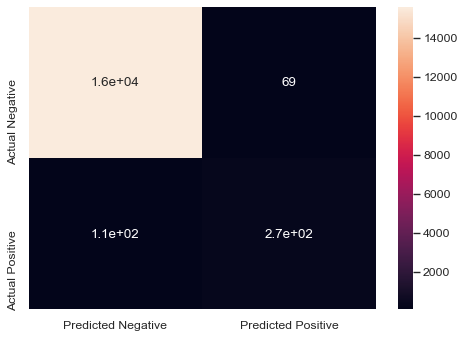

In [127]:
y_test['class'] = np.where(y_test['class']=='pos',1,0)

y_test_pred = np.zeros_like(y_test)

for i,ins in enumerate(df_aps_test_data):
    y_test_pred[i] = fil_clf.classify_instance(ins)
    
y_test_pred = y_test_pred.astype(np.float)

# Confusion Matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

print("Test Data Confusion Matrix:")

figure(figsize=(7,5), dpi=80)

sns.heatmap(cm, annot=True)

In [128]:
# Test Data Performance Measures

d = {'Accuracy': [accuracy_score(y_test, y_test_pred)] , 'Error' : [1-(accuracy_score(y_test, y_test_pred))]}
df_measures = pd.DataFrame(data=d,index=['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
Accuracy                        0.989062
Error                           0.010938

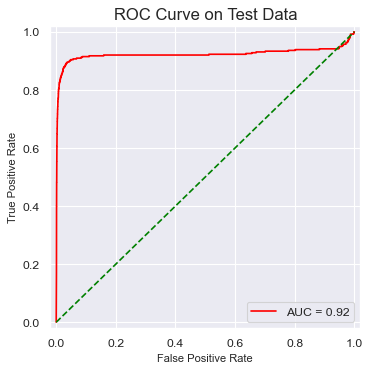

In [129]:
# ROC Curve for Test Data

from sklearn.metrics import roc_curve, auc

y_proba_test = np.zeros((16000,2))

for i,ins in enumerate(df_aps_test_data):
    y_proba_test[i] = fil_clf.distribution_for_instance(ins)
y_proba_test_pos = y_proba_test[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_proba_test_pos)
roc_auc = auc(fpr, tpr)

figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curve on Test Data', fontsize = 15)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [130]:
# AUC for Test Data

d = {'AUC': [roc_auc_score(y_test, y_proba_test_pos)]}
df_measures = pd.DataFrame(data=d,index = ['Test Data Performance Measures'])
df_measures.T

Test Data Performance Measures
AUC                         0.92252

The 5-fold cross-validation error(0.9) is higher than the test error(0.010938), however, it predicts the train data better than the test data(train error- 0.00165).

Compared to building the Logistic Model Trees on imbalanced data, our test error is worse when using SMOTE oversampling. It missclassifies the majority(i.e. 'neg' class) more, but the TPR increases roughly, meaning the ability of classifying the minority class becomes better. For this task, I think we care more about information from the minority class and hope to correctly predict the less prominent class. Therefore, by using oversampling, we lose accuracy for targeting the majority class, but have more tendency to find out the true 'pos' class.

# ISLR

# 6.8.3 Suppose we estimate the regression coefficients in a linear regression model by minimizing for a particular value of s. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

# (a) As we increase s from 0, the training RSS will: i. Increase initially, and then eventually start decreasing in an inverted U shape. ii. Decrease initially, and then eventually start increasing in a U shape. iii. Steadily increase. iv. Steadily decrease. v. Remain constant.

(iv) Steadily decrease - 
As we increase s from 0, we are slowly restricting the regression coefficients lesser due to which they will tend increasing towards their least squares estimates and hence make the model more flexible. Thus the training RSS will steadily decrease as this happens.

# (b) Repeat (a) for test RSS.

(ii) Decrease initially, and then eventually start increasing in a U shape -
As we increase s from 0, we are slowly restricting the regression coefficients lesser due to which they will tend increasing towards their least squares estimates and hence make the model more flexible. However after a point, when the regression coefficients reach their full blown least squares estimates values, the model will start overfitting to the training data and hence the test RSS will first decrease initially but then eventually start increasing in a U shape after the model overfits.

# (c) Repeat (a) for variance.

(iii) Steadily increase -
As we increase s from 0, we are slowly restricting the regression coefficients lesser due to which they will tend increasing towards their least squares estimates and hence make the model more flexible. This leads to a steady increase in variance.

# (d) Repeat (a) for (squared) bias.

(iv) Steadily decrease - 
As we increase s from 0, we are slowly restricting the regression coefficients lesser due to which they will tend increasing towards their least squares estimates and hence make the model more flexible. This leads to a steady decrease in bias.

# (e) Repeat (a) for the irreducible error.

(v) Remain constant - 
The irreducible error, by definition, is independent of the model and therefore also independant of s.

# 6.8.5 It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting. Suppose that n = 2, p = 2, x11 = x12, x21 = x22. Furthermore, suppose that y1+y2 = 0 and x11+x21 = 0 and x12+x22 = 0, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: ˆ β0 = 0.

# (a) Write out the ridge regression optimization problem in this setting.

# (b) Argue that in this setting, the ridge coefficient estimates satisfy ˆ β1 = ˆ β2.

# (c) Write out the lasso optimization problem in this setting.

# (d) Argue that in this setting, the lasso coefficients ˆ β1 and ˆ β2 are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

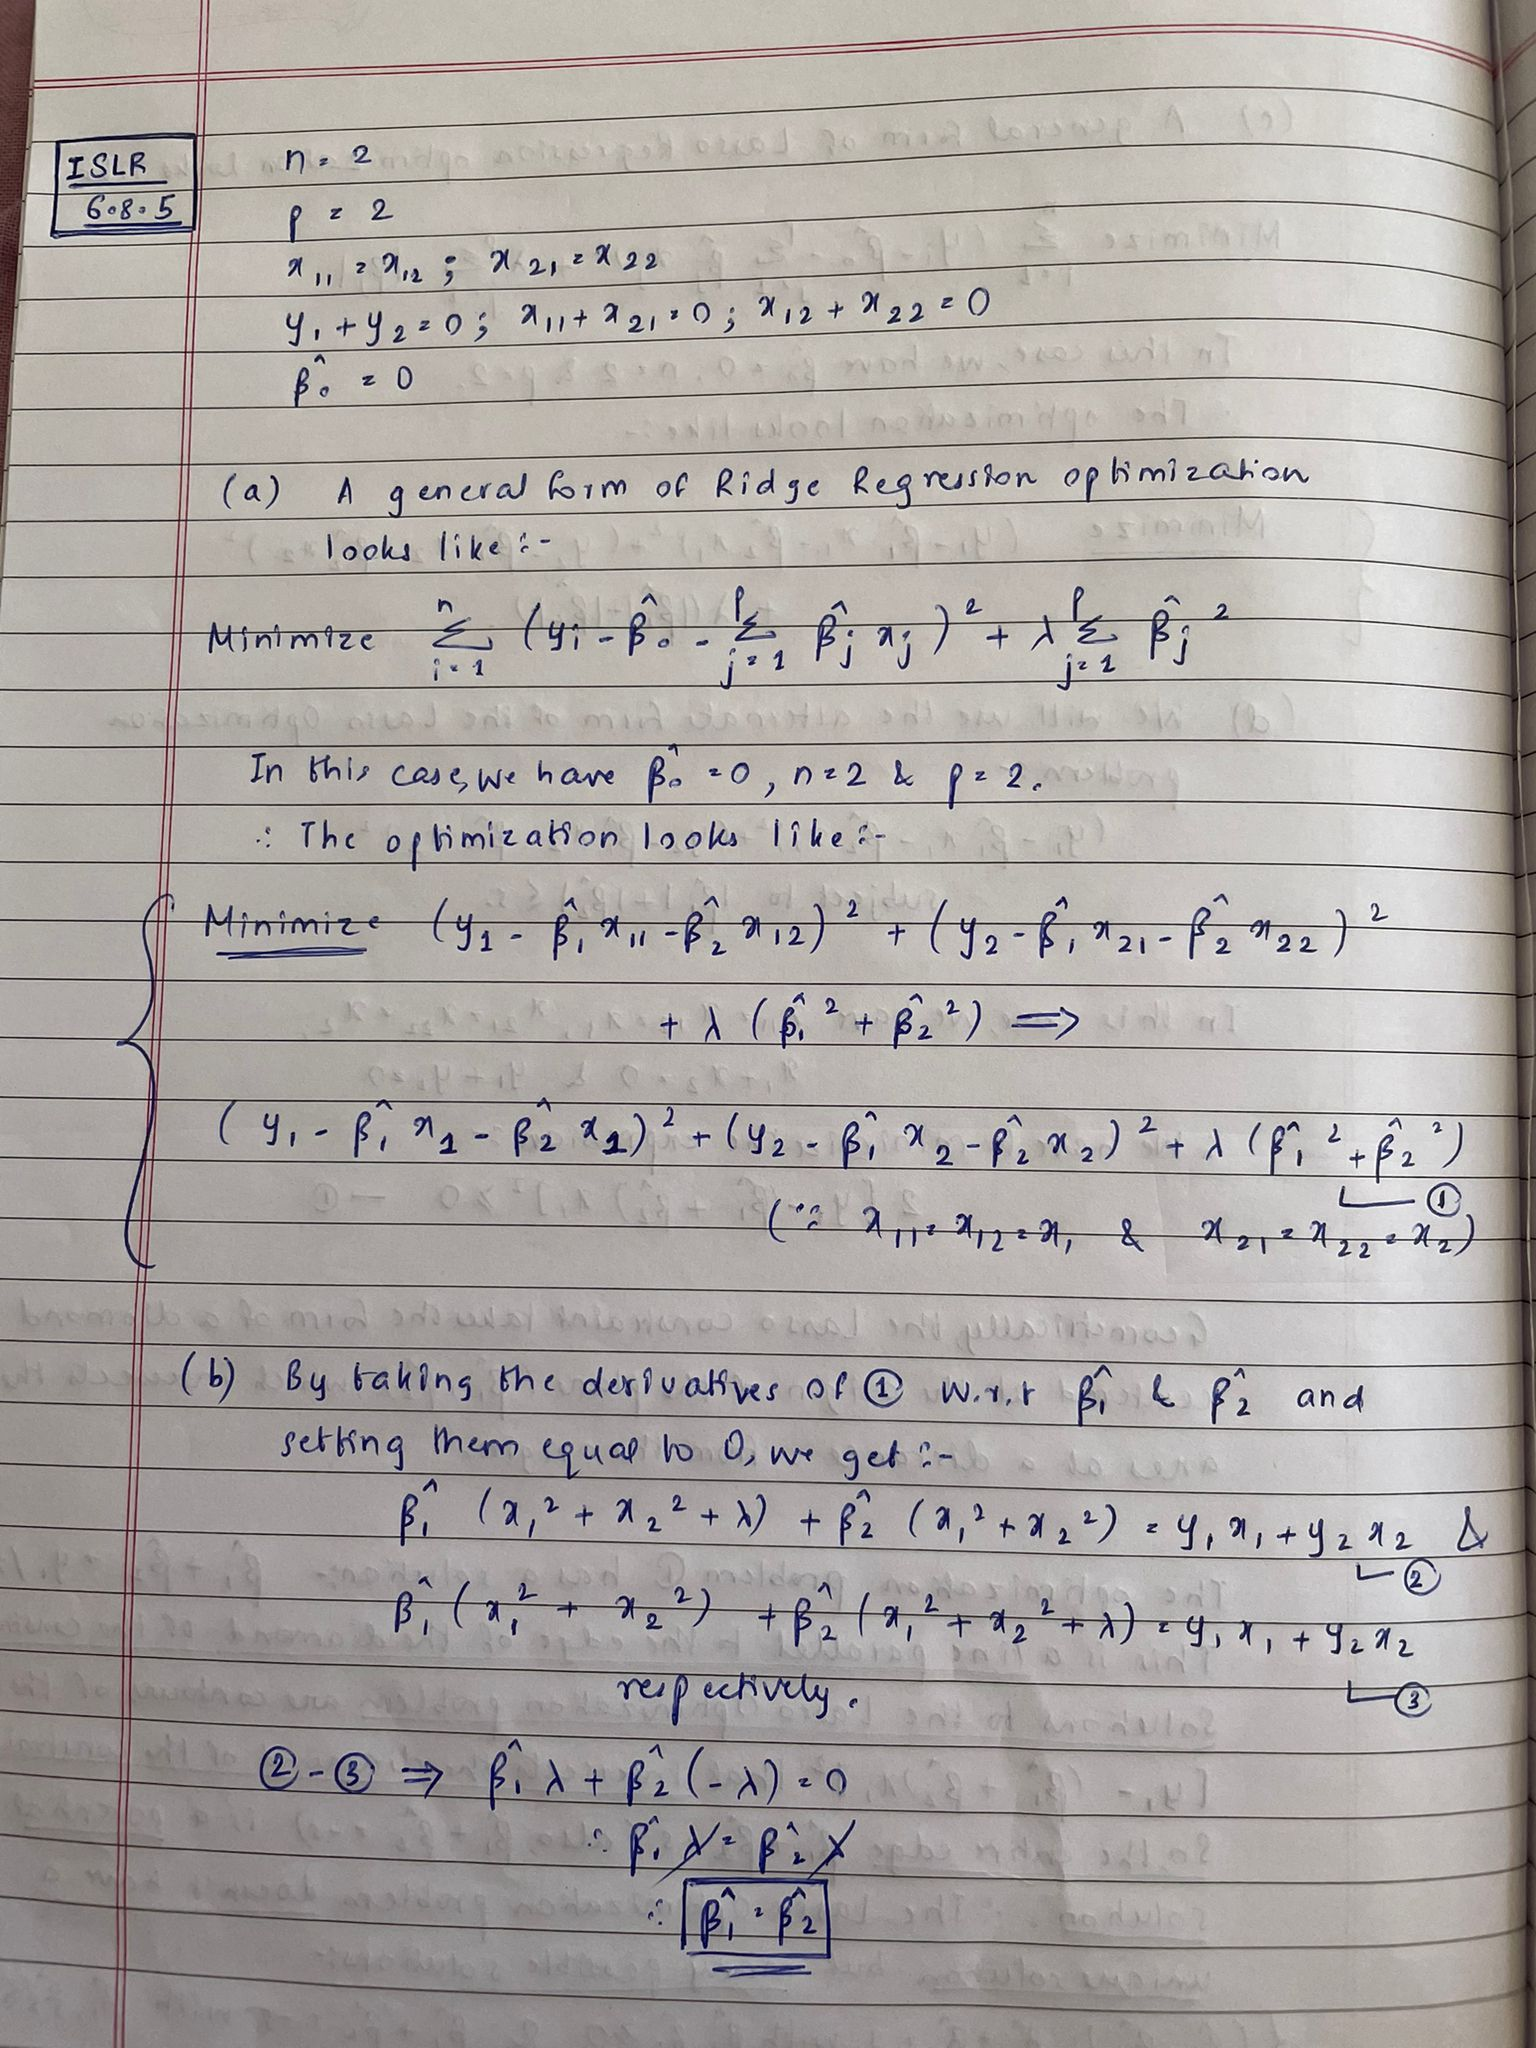

In [131]:
Image(filename="../notebook/images/1.jpeg")

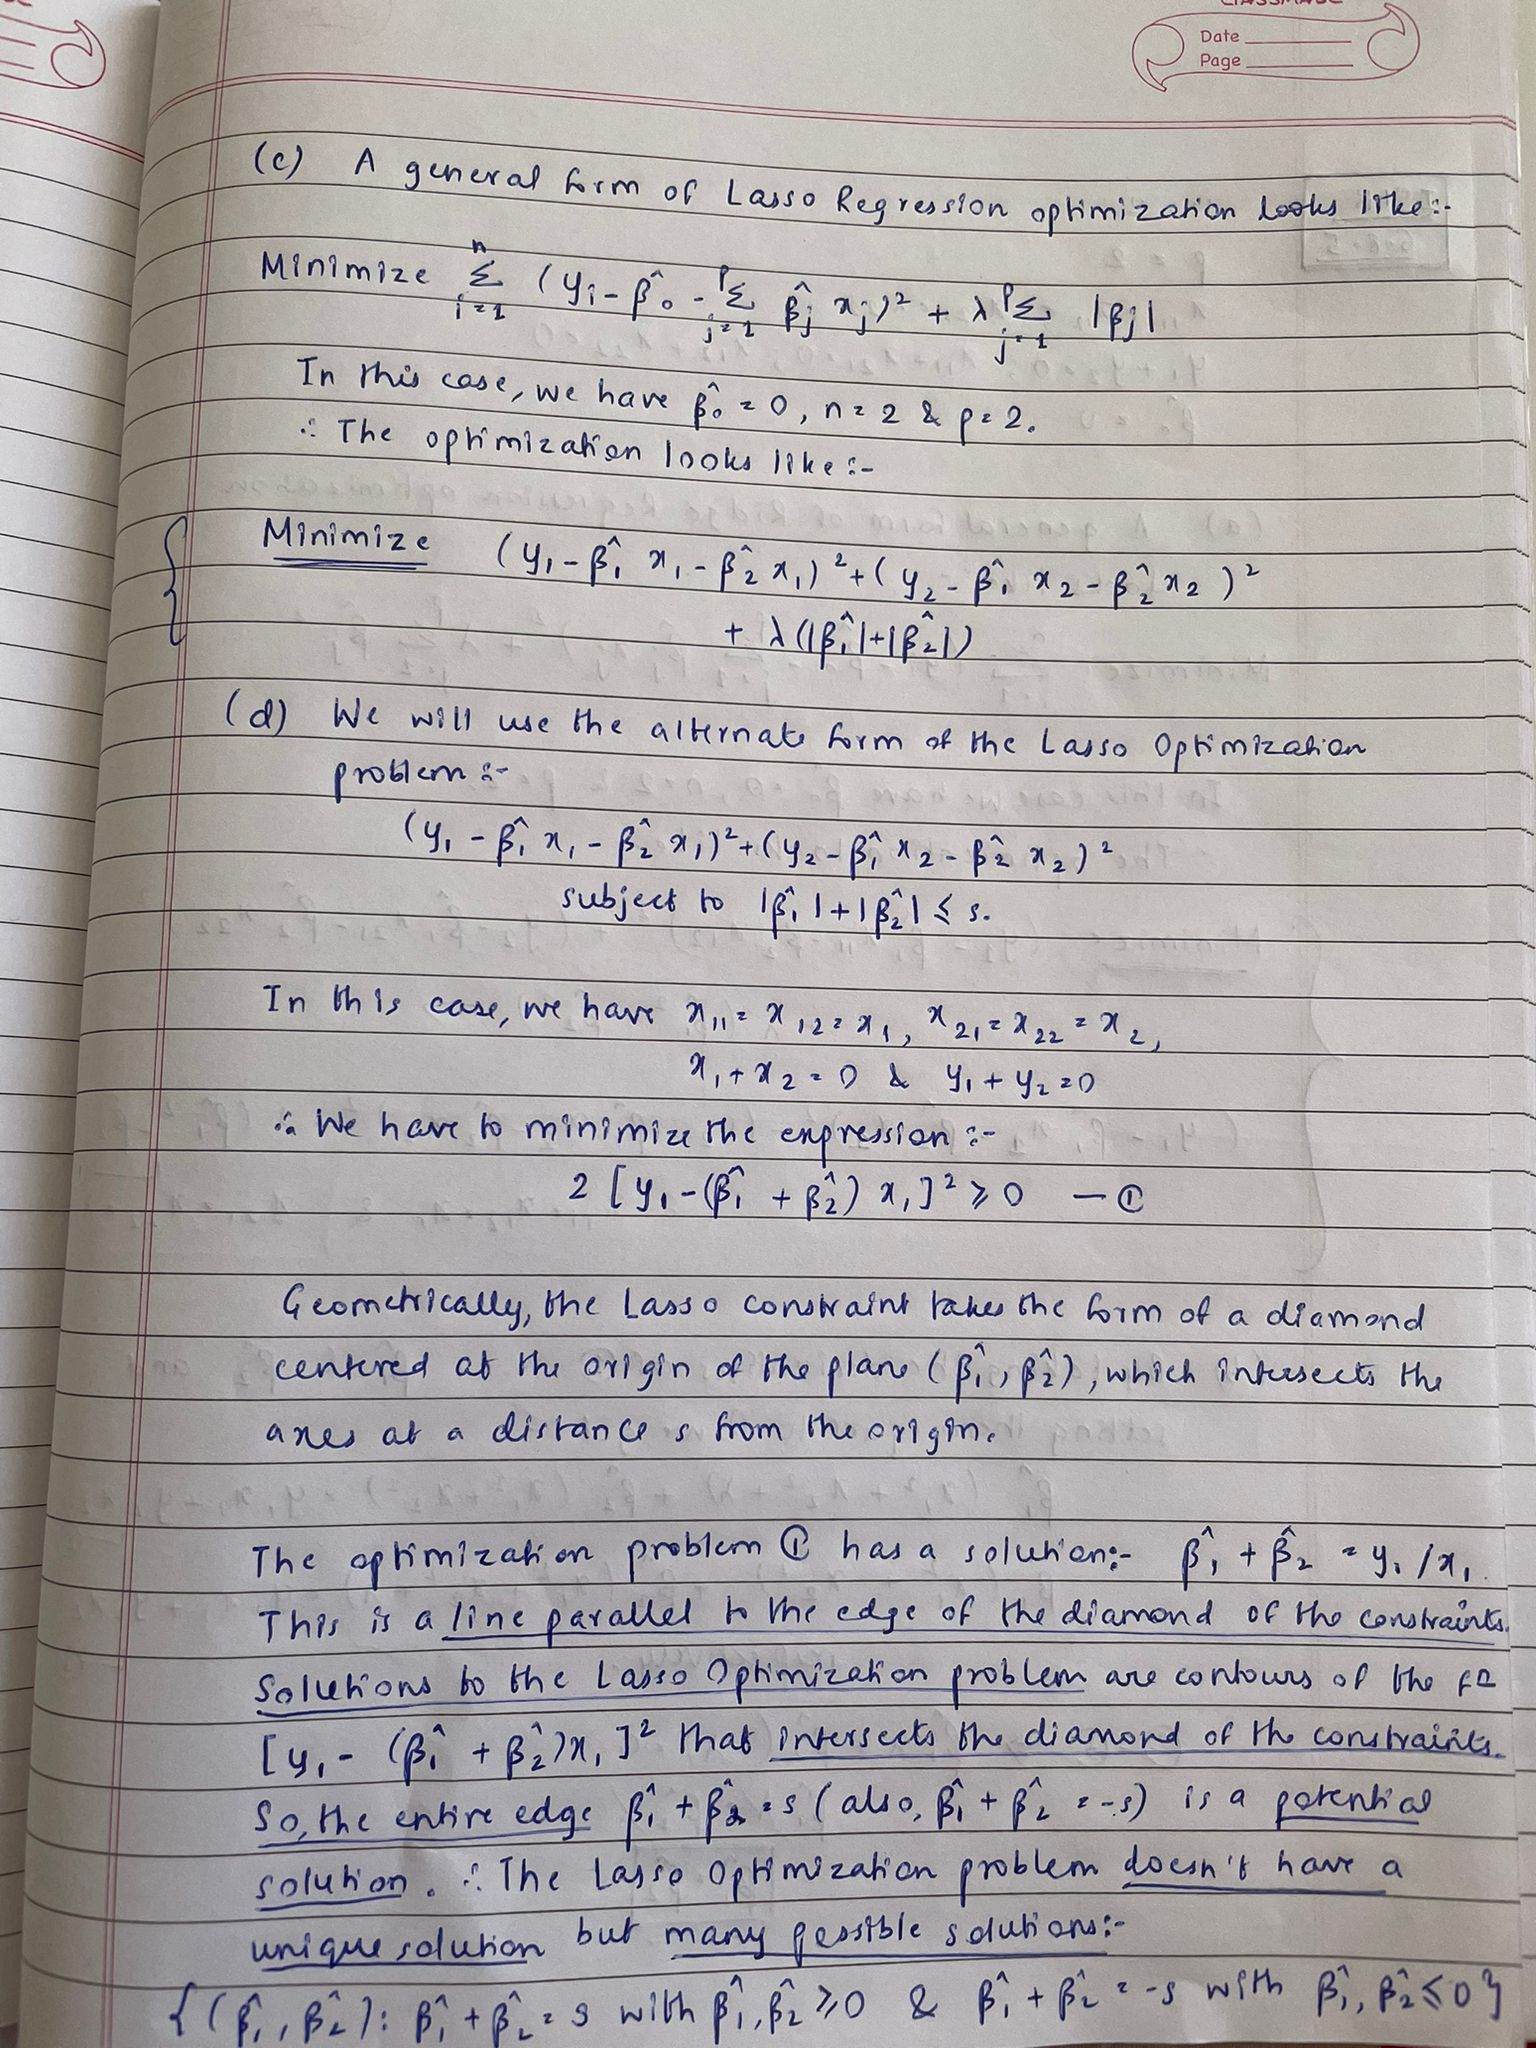

In [132]:
Image(filename="../notebook/images/2.jpeg")

# 8.4.5 Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X): 0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75. There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

With the majority vote approach, we classify X as 'Red' as it is the most commonly occurring class among the ten estimates(Red-6 ,Green-4). (threshold- 0.5)
With the average probability approach, we classify X as 'Green' as the average of the ten probabilities is 0.45. (threshold- 0.5)

# 9.7.3 Here we explore the maximal margin classifier on a toy data set.

# (a) We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label. Obs. X1 X2 Y 1 3 4 Red 2 2 2 Red 3 4 4 Red 4 1 4 Red 5 2 1 Blue 6 4 3 Blue 7 4 1 Blue. Sketch the observations.

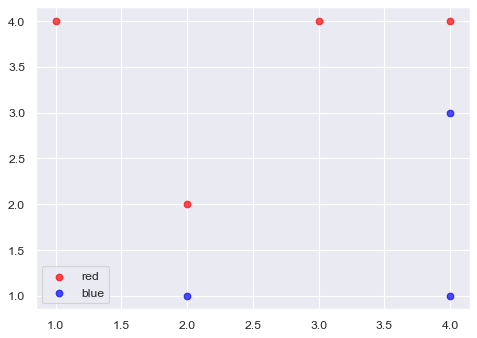

In [133]:
x = np.array([[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1]])
y = np.array([1,1,1,1,0,0,0])

figure(figsize=(7,5), dpi=80)

plt.scatter(x[y == 1, 0], x[y == 1, 1], color='red', label='red', alpha=0.7)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='blue', label='blue',alpha=0.7)

plt.grid(True)
plt.legend()

# (b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane.

To maximize the margin, we need to draw a line to pass through the middle point between (2,2) and (2,1), and the middle point between (4,4) and (4,3). So the optimal separating hyperplane equation is X1 - X2 - 0.5 = 0.

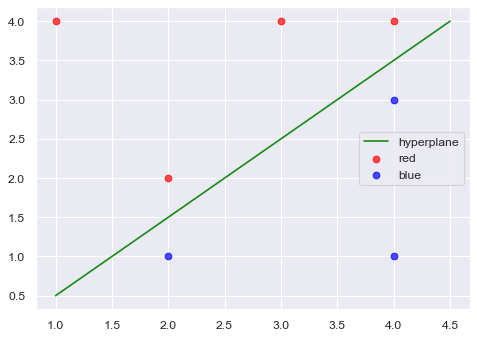

In [134]:
hyperplane_x = np.linspace(1, 4.5, 100)

figure(figsize=(7,5), dpi=80)

plt.scatter(x[y == 1, 0], x[y == 1, 1], color='red', label='red', alpha=0.7)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='blue', label='blue', alpha=0.7)

plt.plot(hyperplane_x, hyperplane_x - 0.5, color='green', label='hyperplane', alpha=0.9)

plt.grid(True)
plt.legend()

# (c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if β0 +β1X1 +β2X2 > 0, and classify to Blue otherwise.” Provide the values for β0, β1, and β2.

The classification rule is “Classify to Red if  X1 − X2 − 0.5 < 0, and classify to Blue otherwise.”
Here, the value of B1 is 1, B2 is -1 and B0 is -0.5.

# (d) On your sketch, indicate the margin for the maximal margin hyperplane.

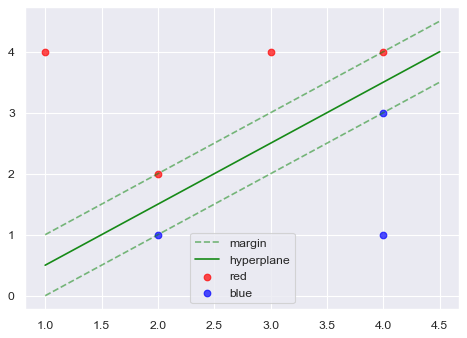

In [135]:
figure(figsize=(7,5), dpi=80)

plt.scatter(x[y == 1, 0], x[y == 1, 1], color='red', label='red', alpha=0.7)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='blue', label='blue',alpha=0.7)

plt.plot(hyperplane_x, hyperplane_x, color='green', linestyle='--',label='margin', alpha=0.5)
plt.plot(hyperplane_x, hyperplane_x - 0.5, color='green', label='hyperplane', alpha=0.9)
plt.plot(hyperplane_x, hyperplane_x - 1, color='green', linestyle='--', alpha=0.5)

plt.grid(True)
plt.legend()

# (e) Indicate the support vectors for the maximal margin classifier.

The support vectors for the maximal margin classifier are the points (2,1), (2,2), (4,3) and (4,4).

# (f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

By examining the plot, it is clear that if we moved the seventh observation i.e. (4,1) slightly, it would not affect the maximal margin hyperplane as (4,1) is not a support vector.

# (g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

We randomly draw a line which only passes through between (2,2) and (2,1), and between (4,4) and (4,3). Only now the line dosen't pass through the exact middle points (2,1.5) and (4,3.5). So the hyperplane equation could be X1 - X2 - 0.4 = 0.

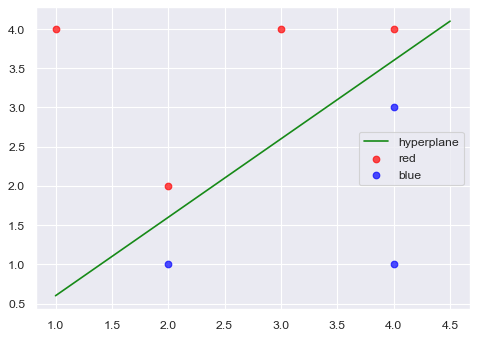

In [136]:
hyperplane_x = np.linspace(1, 4.5, 100)

figure(figsize=(7,5), dpi=80)

plt.scatter(x[y == 1, 0], x[y == 1, 1], color='red', label='red', alpha=0.7)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='blue', label='blue', alpha=0.7)

plt.plot(hyperplane_x, hyperplane_x - 0.4, color='green', label='hyperplane', alpha=0.9)

plt.grid(True)
plt.legend()

# (h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

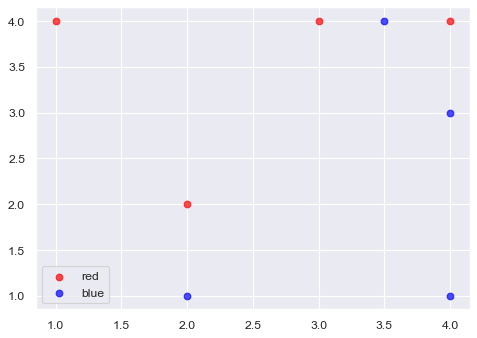

In [137]:
x = np.append(x, [[3.5,4]], axis = 0)
y = np.append(y, [0], axis= 0)

figure(figsize=(7,5), dpi=80)

plt.scatter(x[y == 1, 0], x[y == 1, 1], color='red', label='red', alpha=0.7)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='blue', label='blue',alpha=0.7)

plt.grid(True)
plt.legend()

When the blue point (3.5,4) is added to the plot, the two classes are obviously not separable by a hyperplane anymore.